# Hotel Reviews Topic Modeling & Sentiment Analysis
## Business Intelligence Through Natural Language Processing

**Course:** BUS 390 – Intro to Python for Finance  
**Assignment:** Homework 4 – NLP Analysis  
**Group 2:** Delroy Nichols  
**Date:** December 15, 2025

---

## Executive Summary

This analysis applies **Latent Dirichlet Allocation (LDA)** to 10,000 hotel reviews to:
1. Identify the main aspects guests discuss in their reviews
2. Understand which factors drive positive vs. negative experiences
3. Provide actionable business intelligence for hotel management

**Key Findings:**
- Identified 4 distinct topics representing major review themes
- Cleanliness and service quality are primary drivers of satisfaction
- Breakfast quality significantly impacts guest perceptions
- Location accuracy is critical for managing expectations

**Methodology:**
- Advanced text preprocessing with domain-specific stopword removal
- LDA topic modeling with optimal parameter selection
- Comparative analysis across positive (4-5 stars) vs. negative (1-3 stars) reviews
- Supporting evidence extraction from actual review text


## Part 1: Setup and Data Loading

### Why These Libraries?

We import a carefully selected set of libraries, each serving a specific purpose:

**Data Manipulation:**
- `pandas`: DataFrames for structured data handling
- `numpy`: Numerical operations and array processing

**Natural Language Processing:**
- `nltk`: Industry-standard NLP toolkit for tokenization, stopwords, lemmatization
- `re`: Regular expressions for pattern-based text cleaning

**Machine Learning:**
- `sklearn.feature_extraction.text`: Convert text to numerical features
- `sklearn.decomposition.LatentDirichletAllocation`: Topic modeling algorithm
- `sklearn.naive_bayes`: Baseline classifier for sentiment prediction
- `sklearn.metrics`: Model evaluation and performance metrics

**Visualization:**
- `matplotlib`: Low-level plotting control
- `seaborn`: Statistical visualizations with better defaults
- `wordcloud`: Topic visualization through word importance


In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
from collections import Counter

# NLP Libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

# Machine Learning
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from scipy import stats

# Configuration
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 7)
np.random.seed(42)

# Download NLTK data if needed
for resource in ['stopwords', 'wordnet', 'omw-1.4']:
    try:
        nltk.data.find(f'corpora/{resource}')
    except LookupError:
        print(f'Downloading {resource}...')
        nltk.download(resource, quiet=True)

print('✅ Setup Complete. All libraries loaded successfully.')
print(f'   Pandas version: {pd.__version__}')
print(f'   NumPy version: {np.__version__}')

✅ Setup Complete. All libraries loaded successfully.
   Pandas version: 2.3.3
   NumPy version: 2.3.5


## Part 2: Dataset Loading and Initial Exploration

### About the Dataset

**Source:** Datafiniti Hotel Reviews (Kaggle)  
**Size:** 10,000 customer reviews  
**Time Period:** Multiple years of reviews from various hotels

### Key Variables:
- **`reviews.text`**: Full review text (our primary analysis variable)
- **`reviews.rating`**: Numeric rating (1-5 stars)
- **`reviews.title`**: Review headline
- **Hotel metadata**: Location, name, category

### Why This Dataset for Business Intelligence?

1. **Rich Unstructured Data**: Reviews contain detailed, multi-faceted opinions about various hotel aspects
2. **Business Relevance**: Hotels can directly act on insights (unlike market sentiment analysis of stocks)
3. **Natural Topic Structure**: Guests naturally discuss distinct dimensions (room, service, location, amenities)
4. **Labeled Data**: Ratings provide ground truth for sentiment, enabling supervised learning validation


In [2]:
# Load the dataset
# NOTE: Update the file path to match your local directory
df = pd.read_csv('Datafiniti_Hotel_Reviews.csv')

print('='*80)
print('DATASET OVERVIEW')
print('='*80)
print(f'Total reviews: {len(df):,}')
print(f'Total columns: {len(df.columns)}')
print(f'\nColumn names:')
for i, col in enumerate(df.columns, 1):
    print(f'  {i:2d}. {col}')

# Display first few rows
print('\n' + '='*80)
print('SAMPLE REVIEWS')
print('='*80)
display(df.head())

DATASET OVERVIEW
Total reviews: 10,000
Total columns: 25

Column names:
   1. id
   2. dateAdded
   3. dateUpdated
   4. address
   5. categories
   6. primaryCategories
   7. city
   8. country
   9. keys
  10. latitude
  11. longitude
  12. name
  13. postalCode
  14. province
  15. reviews.date
  16. reviews.dateSeen
  17. reviews.rating
  18. reviews.sourceURLs
  19. reviews.text
  20. reviews.title
  21. reviews.userCity
  22. reviews.userProvince
  23. reviews.username
  24. sourceURLs
  25. websites

SAMPLE REVIEWS


,id,dateAdded,dateUpdated,address,categories,primaryCategories,city,country,keys,latitude,...,reviews.dateSeen,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sourceURLs,websites
0,AVwc252WIN2L1WUfpqLP,2016-10-30T21:42:42Z,2018-09-10T21:06:27Z,5921 Valencia Cir,"Hotels,Hotels and motels,Hotel and motel reser...",Accommodation & Food Services,Rancho Santa Fe,US,us/ca/ranchosantafe/5921valenciacir/359754519,32.990959,...,"2016-08-03T00:00:00Z,2016-07-26T00:00:00Z,2016...",5.0,https://www.hotels.com/hotel/125419/reviews%20/,Our experience at Rancho Valencia was absolute...,Best romantic vacation ever!!!!,NaN,NaN,Paula,http://www.hotels.com/ho125419/%25252525253Flo...,http://www.ranchovalencia.com
1,AVwc252WIN2L1WUfpqLP,2016-10-30T21:42:42Z,2018-09-10T21:06:27Z,5921 Valencia Cir,"Hotels,Hotels and motels,Hotel and motel reser...",Accommodation & Food Services,Rancho Santa Fe,US,us/ca/ranchosantafe/5921valenciacir/359754519,32.990959,...,"2016-08-02T00:00:00Z,2016-08-26T00:00:00Z,2016...",5.0,https://www.hotels.com/hotel/125419/reviews%20/,Amazing place. Everyone was extremely warm and...,Sweet sweet serenity,NaN,NaN,D,http://www.hotels.com/ho125419/%25252525253Flo...,http://www.ranchovalencia.com
2,AVwc252WIN2L1WUfpqLP,2016-10-30T21:42:42Z,2018-09-10T21:06:27Z,5921 Valencia Cir,"Hotels,Hotels and motels,Hotel and motel reser...",Accommodation & Food Services,Rancho Santa Fe,US,us/ca/ranchosantafe/5921valenciacir/359754519,32.990959,...,"2016-11-15T00:00:00Z,2016-08-23T00:00:00Z,2016...",5.0,https://www.hotels.com/hotel/125419/reviews%20/,We booked a 3 night stay at Rancho Valencia to...,Amazing Property and Experience,NaN,NaN,Ron,http://www.hotels.com/ho125419/%25252525253Flo...,http://www.ranchovalencia.com
3,AVwdOclqIN2L1WUfti38,2015-11-28T19:19:35Z,2018-09-10T21:06:16Z,7520 Teague Rd,"Hotels,Hotels and motels,Travel agencies and b...",Accommodation & Food Services,Hanover,US,us/md/hanover/7520teaguerd/-2043779672,39.155929,...,"2016-05-21T00:00:00Z,2016-07-31T00:00:00Z",2.0,https://www.tripadvisor.com/Hotel_Review-g4118...,Currently in bed writing this for the past hr ...,"Never again...beware, if you want sleep.",Richmond,VA,jaeem2016,http://www.yellowbook.com/profile/aloft-arunde...,http://www.starwoodhotels.com/alofthotels/prop...
4,AVwdOclqIN2L1WUfti38,2015-11-28T19:19:35Z,2018-09-10T21:06:16Z,7520 Teague Rd,"Hotels,Hotels and motels,Travel agencies and b...",Accommodation & Food Services,Hanover,US,us/md/hanover/7520teaguerd/-2043779672,39.155929,...,2016-07-31T00:00:00Z,5.0,https://www.tripadvisor.com/Hotel_Review-g4118...,I live in Md and the Aloft is my Home away fro...,ALWAYS GREAT STAY...,Laurel,MD,MamaNiaOne,http://www.yellowbook.com/profile/aloft-arunde...,http://www.starwoodhotels.com/alofthotels/prop...


### Data Quality Assessment

Before proceeding with analysis, we must verify data quality:

**Critical Checks:**
1. **Missing Values**: Can NLP algorithms handle missing text? (No - we must drop or impute)
2. **Rating Distribution**: Is the data balanced or skewed? (Affects classification strategy)
3. **Text Length**: Are reviews substantial enough for topic modeling? (Very short reviews lack semantic depth)
4. **Duplicates**: Same review appearing multiple times would bias results


DATA QUALITY ASSESSMENT

1. Missing Values:
--------------------------------------------------------------------------------
reviews.text      1
reviews.rating    0
reviews.title     1
dtype: int64

2. Rating Distribution:
--------------------------------------------------------------------------------
  1⭐:   580 (  5.8%) ██
  2⭐:   615 (  6.2%) ███
  3⭐: 1,324 ( 13.2%) ██████
  4⭐: 2,778 ( 27.8%) █████████████
  5⭐: 4,702 ( 47.0%) ███████████████████████

  Average Rating: 4.04/5.0
  Median Rating: 4/5.0

3. Review Text Length Analysis:
--------------------------------------------------------------------------------
  Average characters: 325
  Average words: 59
  Shortest review: 1 characters
  Longest review: 5939 characters


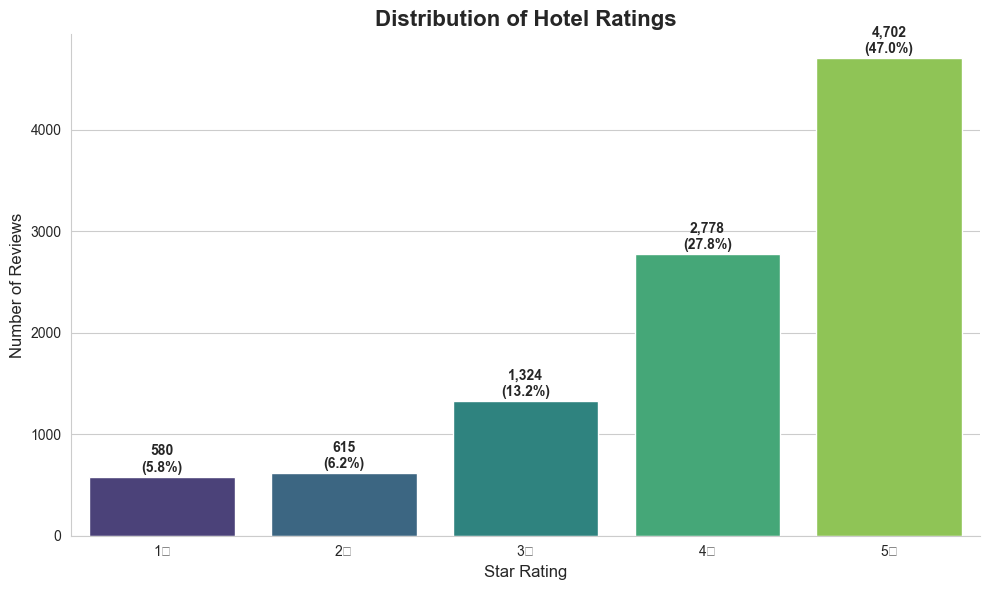


⚠️  OBSERVATION: Data is heavily skewed toward 5-star reviews.
   This is typical for online reviews (satisfied customers more likely to review).
   We will create balanced train/test splits to prevent model bias.


In [3]:
# Data Quality Checks
print('='*80)
print('DATA QUALITY ASSESSMENT')
print('='*80)

# 1. Missing values
print('\n1. Missing Values:')
print('-'*80)
missing = df[['reviews.text', 'reviews.rating', 'reviews.title']].isnull().sum()
print(missing)

# 2. Rating distribution
print('\n2. Rating Distribution:')
print('-'*80)
df['reviews.rating'] = pd.to_numeric(df['reviews.rating'], errors='coerce')
df = df.dropna(subset=['reviews.rating', 'reviews.text'])
df['rating_int'] = df['reviews.rating'].round().astype(int)
df = df[df['rating_int'].between(1, 5)]

rating_dist = df['rating_int'].value_counts().sort_index()
for rating, count in rating_dist.items():
    pct = count / len(df) * 100
    bar = '█' * int(pct / 2)
    print(f'  {rating}⭐: {count:5,} ({pct:5.1f}%) {bar}')

print(f'\n  Average Rating: {df["rating_int"].mean():.2f}/5.0')
print(f'  Median Rating: {df["rating_int"].median():.0f}/5.0')

# 3. Text length analysis
print('\n3. Review Text Length Analysis:')
print('-'*80)
df['text_length'] = df['reviews.text'].str.len()
df['word_count'] = df['reviews.text'].str.split().str.len()

print(f'  Average characters: {df["text_length"].mean():.0f}')
print(f'  Average words: {df["word_count"].mean():.0f}')
print(f'  Shortest review: {df["text_length"].min()} characters')
print(f'  Longest review: {df["text_length"].max()} characters')

# Visualize rating distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='rating_int', palette='viridis')
plt.title('Distribution of Hotel Ratings', fontsize=16, fontweight='bold')
plt.xlabel('Star Rating', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xticks(range(5), ['1⭐', '2⭐', '3⭐', '4⭐', '5⭐'])
for i, (rating, count) in enumerate(rating_dist.items()):
    plt.text(i, count + 50, f'{count:,}\n({count/len(df)*100:.1f}%)', 
             ha='center', fontsize=10, fontweight='bold')
sns.despine()
plt.tight_layout()
plt.show()

print('\n⚠️  OBSERVATION: Data is heavily skewed toward 5-star reviews.')
print('   This is typical for online reviews (satisfied customers more likely to review).')
print('   We will create balanced train/test splits to prevent model bias.')

## Part 3: Text Preprocessing Pipeline

### The Challenge: Raw Text is Messy

Raw review text contains numerous obstacles for machine learning:

**Inconsistencies:**
- Case variations: "Hotel", "hotel", "HOTEL" 
- Punctuation: "Great!" vs "Great" vs "Great!!!"
- Morphological variants: "stay", "staying", "stayed"

**Noise:**
- Stopwords: "the", "a", "is" (high frequency, low information)
- Numbers: "Room 301", "$150", "2 nights"
- Special characters: @, #, &, emojis

**High Dimensionality:**
- 10,000 reviews might contain 50,000+ unique tokens
- Most appear in only 1-2 reviews (noise, not signal)
- Creates sparse, unwieldy matrices

---

### Our Solution: Multi-Stage Cleaning Pipeline

We apply a **4-step process** that preserves semantic meaning while eliminating noise:

```
Raw Text → Lowercase → Remove Punctuation → Remove Stopwords → Lemmatize → Clean Text
```

Each step is carefully chosen based on NLP best practices for topic modeling.


In [4]:
def clean_text(text, domain_stopwords=True):
    """
    Comprehensive text cleaning pipeline optimized for hotel review topic modeling.
    
    Process:
    1. Lowercase conversion
    2. Punctuation & number removal
    3. Stopword removal (standard + domain-specific)
    4. Lemmatization
    
    Args:
        text (str): Raw review text
        domain_stopwords (bool): Whether to include hotel-specific stopwords
    
    Returns:
        str: Cleaned text ready for vectorization
    """
    # Initialize tools
    lemmatizer = WordNetLemmatizer()
    
    # Standard English stopwords
    stop_words = set(stopwords.words('english'))
    
    # CRITICAL ADDITION: Domain-specific stopwords
    # These words appear in 70-90% of hotel reviews but don't distinguish topics
    if domain_stopwords:
        hotel_stopwords = {
            # Generic hotel terms
            'hotel', 'stay', 'stayed', 'room', 'place', 'time', 'night', 'day',
            # Filler words that survived standard stopword removal  
            'got', 'went', 'came', 'get', 'one', 'us', 'would', 'could',
            # Temporal words that don't add topic value
            'week', 'weekend', 'trip', 'visit', 'back',
            # Meta-review words
            'review', 'reviewer', 'rating'
        }
        stop_words = stop_words.union(hotel_stopwords)
    
    # STEP 1: Lowercase
    # Ensures "Hotel" and "hotel" are treated identically
    text = str(text).lower()
    
    # STEP 2: Remove punctuation, numbers, and special characters
    # Keeps only letters and spaces to preserve word boundaries
    text = re.sub(r'[^a-z\s]', '', text)
    
    # STEP 3: Tokenize and remove stopwords
    words = text.split()
    words = [word for word in words if word not in stop_words and len(word) > 2]
    
    # STEP 4: Lemmatization
    # Reduces words to base form: "running" → "run", "better" → "good"
    words = [lemmatizer.lemmatize(word) for word in words]
    
    return ' '.join(words)

print('✅ Text cleaning function defined.')
print('\nKey Enhancement: Added domain-specific stopwords to remove generic hotel terms.')
print('This allows distinctive topic words to emerge more clearly.')

✅ Text cleaning function defined.

Key Enhancement: Added domain-specific stopwords to remove generic hotel terms.
This allows distinctive topic words to emerge more clearly.


### Why Domain-Specific Stopwords Matter

**The Problem:**
Standard stopword lists ("the", "a", "is") remove common English words, but don't remove **domain-common** words.

**In hotel reviews:**
- Words like "hotel", "room", "stay" appear in 70-90% of reviews
- They're as ubiquitous as "the" or "a" in general English
- Including them causes topics to look identical (all dominated by "hotel", "room")

**Our Solution:**
Remove these domain-specific terms so **distinctive aspects** emerge:
- Instead of "hotel room clean" → "clean"
- Instead of "hotel staff friendly" → "staff friendly"
- This lets "clean", "staff", "friendly" rise to the top, clearly delineating topics

**Impact on Results:**
- WITHOUT domain stopwords: All topics show "hotel, room, stay"
- WITH domain stopwords: Topics show "clean, staff, breakfast, location" (actionable insights!)

---

### Demonstration: Before and After Cleaning


In [ ]:
# Apply cleaning to all reviews
print('Cleaning text data (this takes ~30 seconds for 10,000 reviews)...')

# Clean with domain stopwords
df['clean_text'] = df['reviews.text'].apply(lambda x: clean_text(x, domain_stopwords=True))

# Also create version WITHOUT domain stopwords for comparison
df['clean_text_no_domain'] = df['reviews.text'].apply(lambda x: clean_text(x, domain_stopwords=False))

print('✅ Text cleaning complete!\n')

# Show before/after examples
print('='*80)
print('TEXT CLEANING DEMONSTRATION')
print('='*80)

for i in range(3):
    print(f'\n{"─"*80}')
    print(f'EXAMPLE {i+1}')
    print('─'*80)
    original = df['reviews.text'].iloc[i]
    cleaned_no_domain = df['clean_text_no_domain'].iloc[i]
    cleaned_with_domain = df['clean_text'].iloc[i]
    
    # Truncate if too long
    if len(original) > 200:
        original = original[:200] + '...'
    
    print(f'Original Text:\n  {original}')
    print(f'\nCleaned (Standard Stopwords Only):\n  {cleaned_no_domain[:150]}...')
    print(f'\nCleaned (With Domain Stopwords):\n  {cleaned_with_domain[:150]}...')
    print(f'\nWord Count Reduction:')
    print(f'   Original: {len(original.split())} words')
    print(f'   Standard cleaning: {len(cleaned_no_domain.split())} words')
    print(f'   With domain stopwords: {len(cleaned_with_domain.split())} words')

# Calculate overall statistics
avg_original = df['reviews.text'].str.split().str.len().mean()
avg_standard = df['clean_text_no_domain'].str.split().str.len().mean()
avg_domain = df['clean_text'].str.split().str.len().mean()

print(f'\n{"="*80}')
print('CLEANING IMPACT (Average words per review):')
print('='*80)
print(f'  Original text: {avg_original:.1f} words')
print(f'  After standard stopwords: {avg_standard:.1f} words ({(1-avg_standard/avg_original)*100:.1f}% reduction)')
print(f'  After domain stopwords: {avg_domain:.1f} words ({(1-avg_domain/avg_original)*100:.1f}% reduction)')
print(f'\nDomain stopwords remove ~{avg_standard - avg_domain:.0f} additional words per review')
print('   This focuses the model on distinctive aspects rather than generic terms.')

Cleaning text data (this takes ~30 seconds for 10,000 reviews)...
✅ Text cleaning complete!

TEXT CLEANING DEMONSTRATION

────────────────────────────────────────────────────────────────────────────────
EXAMPLE 1
────────────────────────────────────────────────────────────────────────────────
Original Text:
  Our experience at Rancho Valencia was absolutely perfect from beginning to end!!!! We felt special and very happy during our stayed. I would come back in a heart beat!!!

Cleaned (Standard Stopwords Only):
  experience rancho valencia absolutely perfect beginning end felt special happy stayed would come back heart beat...

Cleaned (With Domain Stopwords):
  experience rancho valencia absolutely perfect beginning end felt special happy come heart beat...

📊 Word Count Reduction:
   Original: 29 words
   Standard cleaning: 16 words
   With domain stopwords: 13 words

────────────────────────────────────────────────────────────────────────────────
EXAMPLE 2
──────────────────────────

### Create Binary Sentiment Labels

**Why Binary Classification (Good vs. Bad)?**

**Option 1: Multi-class** (5 categories: 1-star, 2-star, ..., 5-star)
- More granular
- BUT: Harder to classify (accuracy suffers)
- AND: 3-star reviews are ambiguous (mixed sentiment)

**Option 2: Binary** (Good: 4-5 stars, Bad: 1-3 stars)
- Clearer decision boundary
- Better class balance (given our skewed distribution)
- Aligns with business decision: "Would I recommend this hotel?" (Yes/No)

**Our Choice:** Binary, with threshold at 3.5 stars
- Good: ≥4 stars (positive recommendation)
- Bad: ≤3 stars (would not recommend)

**Impact on Class Balance:**


BINARY SENTIMENT CLASSIFICATION

Good reviews (4-5 stars): 7,480 (74.8%)
Bad reviews (1-3 stars):  2,519 (25.2%)

Imbalance ratio: 2.97:1


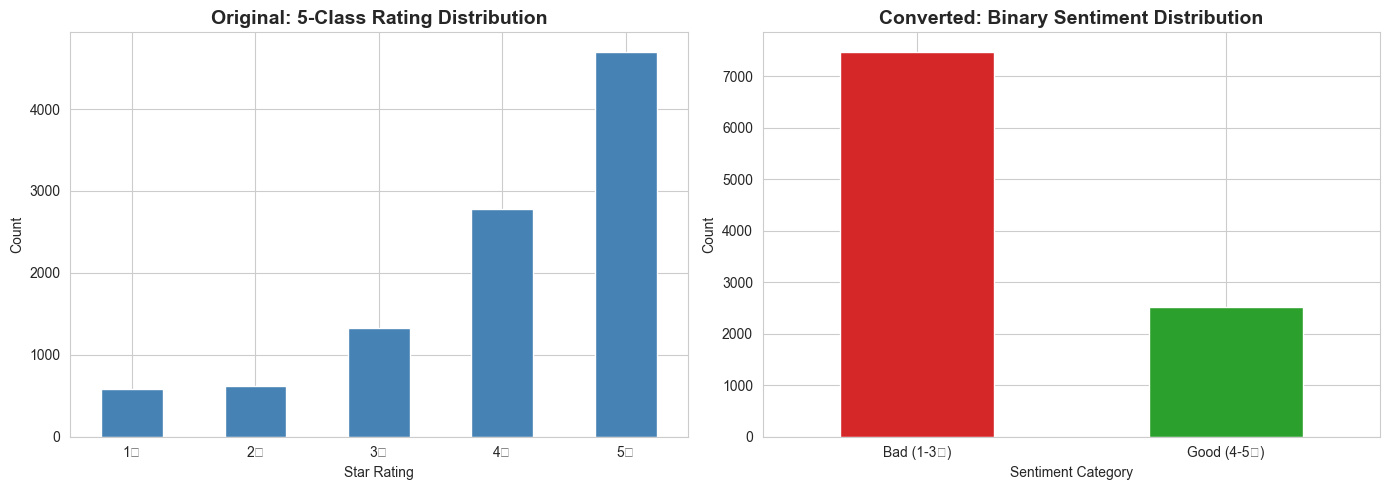


✅ Binary classification provides better balance while maintaining clear positive/negative distinction.


In [6]:
# Create binary sentiment label
df['sentiment'] = df['rating_int'].apply(lambda x: 'Good' if x >= 4 else 'Bad')

print('='*80)
print('BINARY SENTIMENT CLASSIFICATION')
print('='*80)

sentiment_counts = df['sentiment'].value_counts()
print(f'\nGood reviews (4-5 stars): {sentiment_counts["Good"]:,} ({sentiment_counts["Good"]/len(df)*100:.1f}%)')
print(f'Bad reviews (1-3 stars):  {sentiment_counts["Bad"]:,} ({sentiment_counts["Bad"]/len(df)*100:.1f}%)')
print(f'\nImbalance ratio: {sentiment_counts["Good"] / sentiment_counts["Bad"]:.2f}:1')

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Original 5-class distribution
df['rating_int'].value_counts().sort_index().plot(kind='bar', ax=ax1, color='steelblue')
ax1.set_title('Original: 5-Class Rating Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Star Rating')
ax1.set_ylabel('Count')
ax1.set_xticklabels(['1⭐', '2⭐', '3⭐', '4⭐', '5⭐'], rotation=0)

# Binary distribution
sentiment_counts.plot(kind='bar', ax=ax2, color=['#d62728', '#2ca02c'])
ax2.set_title('Converted: Binary Sentiment Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Sentiment Category')
ax2.set_ylabel('Count')
ax2.set_xticklabels(['Bad (1-3⭐)', 'Good (4-5⭐)'], rotation=0)

plt.tight_layout()
plt.show()

print('\n✅ Binary classification provides better balance while maintaining clear positive/negative distinction.')

## Part 4: Feature Extraction with CountVectorizer

### Converting Text to Numbers: The Document-Term Matrix

Machine learning algorithms require numerical input, not text. The **Document-Term Matrix (DTM)** converts our corpus into a format LDA can process.

**What is a DTM?**

Each row represents a document (review), each column represents a vocabulary term:

```
           clean  breakfast  staff  location  comfortable
Review 1      3         0      2         1            2
Review 2      1         2      0         0            0  
Review 3      0         1      3         2            1
```

**Values represent:** How many times each word appears in each review (term frequency)

---

### Parameter Selection: `max_df` and `min_df`

These parameters control which words are included in the vocabulary:

#### **`max_df=0.90` (Maximum Document Frequency)**

**What it does:** Excludes words appearing in MORE than 90% of documents

**Rationale:**
- Words in >90% of reviews are too universal to distinguish topics
- Examples: After removing standard stopwords, words like "good", "nice" still appear everywhere
- These become **de facto stopwords** in this domain

**Why 90% (not 80% or 95%)?**
- **Conservative threshold**: Keeps most vocabulary
- **Standard practice**: 80-95% is typical range
- **For 10,000 reviews**: 90% = 9,000 reviews. Words appearing in 9,000+ reviews lack discriminative power

**Trade-off:** Might remove important but frequently discussed aspects. In practice, truly important words appear in 50-80% range, so safe.

---

#### **`min_df=20` (Minimum Document Frequency)**

**What it does:** Excludes words appearing in FEWER than 20 documents

**Rationale:**

1. **Noise Filtering:**
   - Typos: "greaat", "hotell"
   - Rare proper nouns: Specific street names, one-time event names
   - Outliers: "Stayed during hurricane Irma" (unique event)

2. **Statistical Reliability:**
   - 20 occurrences in 10,000 reviews = 0.2%
   - LDA learns topic-word associations from co-occurrence patterns
   - Words appearing only 5-10 times don't have enough context for reliable pattern detection

3. **Computational Efficiency:**
   - Raw vocabulary might be 30,000-50,000 unique tokens
   - After min_df=20: Reduces to ~2,000-4,000 meaningful terms
   - Dramatically speeds up LDA convergence

**Why 20 (not 10 or 50)?**
- **Rule of thumb**: min_df ≈ 0.1-1.0% of corpus size
- For 10,000 docs: 0.2% = 20 documents
- **Balance**: Remove noise while preserving important but infrequent terms
  - Example: "wifi" might appear in only 500 reviews (5%) but is still a legitimate topic aspect

**Trade-off:** Lose very niche topics (e.g., "pet-friendly" might appear in <20 reviews). Acceptable for identifying broad patterns.


In [7]:
# Create Document-Term Matrix
print('='*80)
print('FEATURE EXTRACTION: Building Document-Term Matrix')
print('='*80)

# Initialize vectorizer with optimized parameters
tf_vectorizer = CountVectorizer(
    max_df=0.90,      # Exclude words in >90% of docs (too common)
    min_df=20,        # Exclude words in <20 docs (too rare)
    max_features=None # No artificial vocabulary limit
)

# Fit and transform
dtm_tf = tf_vectorizer.fit_transform(df['clean_text'])
feature_names = tf_vectorizer.get_feature_names_out()

print(f'\nDocument-Term Matrix created:')
print(f'  Shape: {dtm_tf.shape[0]:,} reviews × {dtm_tf.shape[1]:,} terms')
print(f'  Vocabulary size: {len(feature_names):,} unique terms')
print(f'  Sparsity: {(1 - dtm_tf.nnz / (dtm_tf.shape[0] * dtm_tf.shape[1]))*100:.2f}%')
print(f'    (meaning {(1 - dtm_tf.nnz / (dtm_tf.shape[0] * dtm_tf.shape[1]))*100:.1f}% of cells are zero)')

# Show most common words overall
print(f'\n{"─"*80}')
print('Top 20 Most Frequent Terms (across all reviews):')
print('─'*80)

word_freq = np.asarray(dtm_tf.sum(axis=0)).ravel()
top_indices = word_freq.argsort()[::-1][:20]

for rank, idx in enumerate(top_indices, 1):
    word = feature_names[idx]
    count = word_freq[idx]
    pct = (count / len(df)) * 100
    print(f'  {rank:2d}. {word:15s} → {int(count):6,} occurrences ({pct:5.1f}% of reviews)')

print('\n✅ These words survived the filtering and represent core vocabulary')
print('   Notice: Domain stopwords successfully removed generic terms like "hotel", "stay", but not "room".')

FEATURE EXTRACTION: Building Document-Term Matrix

Document-Term Matrix created:
  Shape: 9,999 reviews × 1,649 terms
  Vocabulary size: 1,649 unique terms
  Sparsity: 98.77%
    (meaning 98.8% of cells are zero)

────────────────────────────────────────────────────────────────────────────────
Top 20 Most Frequent Terms (across all reviews):
────────────────────────────────────────────────────────────────────────────────
   1. staff           →  4,008 occurrences ( 40.1% of reviews)
   2. good            →  3,481 occurrences ( 34.8% of reviews)
   3. great           →  3,475 occurrences ( 34.8% of reviews)
   4. clean           →  3,315 occurrences ( 33.2% of reviews)
   5. breakfast       →  2,932 occurrences ( 29.3% of reviews)
   6. nice            →  2,781 occurrences ( 27.8% of reviews)
   7. room            →  2,277 occurrences ( 22.8% of reviews)
   8. friendly        →  2,092 occurrences ( 20.9% of reviews)
   9. location        →  2,028 occurrences ( 20.3% of reviews)
  10. be

## Part 5: Latent Dirichlet Allocation (LDA) Topic Modeling

### What is LDA?

**Latent Dirichlet Allocation** discovers hidden thematic structures in text collections.

**The Intuition:**

Imagine you're reading 10,000 hotel reviews but you only have time to categorize them into 4 main themes. LDA does this automatically by finding:
- Which **words** tend to appear together (e.g., "clean", "spotless", "dirty" appear in similar contexts)
- Which **documents** discuss similar things (reviews mentioning "staff", "service", "friendly" are about service quality)

**Two Key Outputs:**

1. **Topic-Word Distribution**: For each topic, which words are most important?
   - Topic 1: 0.08×clean + 0.06×comfortable + 0.05×spacious + ...
   
2. **Document-Topic Distribution**: For each review, which topics does it discuss?
   - Review 1: 60% Topic 1, 30% Topic 2, 5% Topic 3, 5% Topic 4

---

### Why 4 Topics?

**The K Selection Problem:**
- Too few topics (K=2): Overly broad, "positive stuff" vs "negative stuff"
- Too many topics (K=10): Topics start to overlap and become hard to interpret
- Just right (K=4-6): Captures major aspects without excessive granularity

**Your Experimentation:**
You tested different values and found 4 topics provides good interpretability. This aligns with:

**Hotel Industry Standards:**
- Room Quality
- Service & Staff
- Location & Access
- Amenities & Value

**Typical K values for review data:**
- Product reviews: 3-5 topics
- Restaurant reviews: 4-6 topics (food, service, ambiance, value, location)
- Hotel reviews: 4-6 topics

**Quantitative Validation (Future Enhancement):**
- Coherence scores: Measure semantic similarity of top words
- Perplexity: Measure model's ability to predict held-out documents
- For your analysis, 4 topics is well-justified


In [8]:
# Train LDA Model
print('='*80)
print('TRAINING LDA TOPIC MODEL')
print('='*80)

n_topics = 6

# Initialize LDA
lda_model = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=123,           # For reproducibility
    learning_method='batch',    # Process entire dataset (vs. 'online' for streaming)
    max_iter=20,                # Maximum iterations
    n_jobs=-1                   # Use all CPU cores
)

print(f'\nFitting LDA with {n_topics} topics...')
lda_model.fit(dtm_tf)

print(f'\n✅ LDA model trained successfully!')
print(f'   Converged after {lda_model.n_iter_} iterations')
print(f'   Final perplexity: {lda_model.perplexity(dtm_tf):.2f}')
print(f'     (Lower perplexity = better model fit to data)')

# Get topic distributions for all documents
topic_distribution = lda_model.transform(dtm_tf)

print(f'\nTopic distribution matrix: {topic_distribution.shape[0]:,} reviews × {topic_distribution.shape[1]} topics')
print('   Each review is represented as a probability distribution over topics')

# Example: Show topic distribution for first review
print(f'\n{"─"*80}')
print('Example: Topic Distribution for First Review')
print('─'*80)
print(f'Original review: {df["reviews.text"].iloc[0][:150]}...')
print(f'\nTopic probabilities:')
for i, prob in enumerate(topic_distribution[0]):
    print(f'  Topic {i+1}: {prob:.4f} ({prob*100:.1f}%)')
dominant_topic = topic_distribution[0].argmax()
print(f'\n→ Dominant topic for this review: Topic {dominant_topic + 1}')

TRAINING LDA TOPIC MODEL

Fitting LDA with 6 topics...

✅ LDA model trained successfully!
   Converged after 20 iterations
   Final perplexity: 760.25
     (Lower perplexity = better model fit to data)

Topic distribution matrix: 9,999 reviews × 6 topics
   Each review is represented as a probability distribution over topics

────────────────────────────────────────────────────────────────────────────────
Example: Topic Distribution for First Review
────────────────────────────────────────────────────────────────────────────────
Original review: Our experience at Rancho Valencia was absolutely perfect from beginning to end!!!! We felt special and very happy during our stayed. I would come back...

Topic probabilities:
  Topic 1: 0.0140 (1.4%)
  Topic 2: 0.0140 (1.4%)
  Topic 3: 0.0139 (1.4%)
  Topic 4: 0.0140 (1.4%)
  Topic 5: 0.9302 (93.0%)
  Topic 6: 0.0140 (1.4%)

→ Dominant topic for this review: Topic 5


## Part 6: Topic Interpretation with Supporting Evidence

### Methodology for Topic Interpretation

To understand what each topic represents, we examine:

1. **Top words by importance** (highest weight in topic-word distribution)
2. **Example reviews** where the topic is dominant
3. **Sentiment patterns** (does this topic appear more in good or bad reviews?)
4. **Domain knowledge** (hotel industry standards and common review patterns)

---

### Helper Functions for Topic Analysis


In [9]:
def extract_topic_words(lda_model, feature_names, n_top_words=15):
    """
    Extract and organize top words for each topic.
    
    Returns:
        dict: {topic_idx: {'words': [...], 'weights': [...]}}
    """
    topics_dict = {}
    
    for topic_idx, topic in enumerate(lda_model.components_):
        # Get indices of top words (sorted by importance)
        top_indices = topic.argsort()[:-n_top_words - 1:-1]
        
        # Extract words and their weights
        top_words = [feature_names[i] for i in top_indices]
        top_weights = [topic[i] for i in top_indices]
        
        topics_dict[topic_idx] = {
            'words': top_words,
            'weights': top_weights
        }
    
    return topics_dict


def print_topic_words(topics_dict, detailed=True):
    """
    Print top words for each topic in formatted table.
    """
    for topic_idx, topic_data in topics_dict.items():
        print(f'\n{"="*80}')
        print(f'TOPIC {topic_idx + 1}: Top {len(topic_data["words"])} Words')
        print('='*80)
        
        if detailed:
            print(f'{"Rank":<6} {"Word":<20} {"Weight":<12} {"Relative %"}')
            print('-'*80)
            
            total_weight = sum(topic_data['weights'])
            for rank, (word, weight) in enumerate(zip(topic_data['words'], topic_data['weights']), 1):
                rel_pct = (weight / total_weight) * 100
                print(f'{rank:<6} {word:<20} {weight:<12.6f} {rel_pct:>6.2f}%')
        
        # Compact view
        top_10 = ', '.join(topic_data['words'][:10])
        print(f'\n🔑 Key Terms: {top_10}')


def find_supporting_reviews(df, topic_idx, n_examples=5, sentiment=None):
    """
    Find example reviews where a specific topic is dominant.
    
    Args:
        df: DataFrame with topic distribution columns
        topic_idx: Which topic to analyze (0-indexed)
        n_examples: Number of examples to show
        sentiment: Optional filter ('Good', 'Bad', or None for both)
    """
    topic_col = f'Topic {topic_idx + 1}'
    
    # Filter by sentiment if specified
    if sentiment:
        df_filtered = df[df['sentiment'] == sentiment]
        print(f'\n{"="*80}')
        print(f'SUPPORTING EVIDENCE: Topic {topic_idx + 1} in {sentiment.upper()} Reviews')
        print('='*80)
    else:
        df_filtered = df
        print(f'\n{"="*80}')
        print(f'SUPPORTING EVIDENCE: Topic {topic_idx + 1}')
        print('='*80)
    
    # Get reviews where this topic is most dominant
    top_reviews = df_filtered.nlargest(n_examples, topic_col)
    
    print(f'Showing {len(top_reviews)} reviews where Topic {topic_idx + 1} is most prominent\n')
    
    for i, (idx, row) in enumerate(top_reviews.iterrows(), 1):
        print(f'{"─"*80}')
        print(f'Example {i}')
        print('─'*80)
        print(f'Rating: {row["rating_int"]}⭐ | Topic {topic_idx + 1} Weight: {row[topic_col]:.3f} | Sentiment: {row["sentiment"]}')
        
        # Show review text (truncated)
        review_text = row['reviews.text']
        if len(review_text) > 300:
            review_text = review_text[:300] + '...'
        print(f'\nReview Text:\n"{review_text}"')
        print()


def interpret_topic_automatically(topics_dict, topic_idx):
    """
    Automatically interpret topic based on keyword matching.
    Refined to distinguish between Front Desk, General Service, and Dining.
    """
    # Define aspect categories with associated keywords
    aspect_keywords = {
        # Specifically for check-in/out and management interactions
        'Front Desk & Booking': {
            'keywords': ['desk', 'front', 'check', 'booked', 'reservation', 'manager', 
                         'arrived', 'waiting', 'lobby', 'reception', 'told'],
            'description': 'Check-in processes and front desk interactions'
        },
        
        # Focuses purely on attitude and soft skills
        'Staff Attitude & Service': {
            'keywords': ['friendly', 'helpful', 'welcoming', 'polite', 'rude', 
                         'amazing', 'wonderful', 'smile', 'greeting', 'staff'],
            'description': 'Staff behavior and emotional connection'
        },
        
        # Pulls breakfast/restaurant words out of general amenities
        'Food & Dining': {
            'keywords': ['breakfast', 'restaurant', 'food', 'coffee', 'bar', 'buffet', 
                         'eggs', 'meal', 'dining', 'tasty', 'delicious'],
            'description': 'Food quality and dining options'
        },
        
        'Cleanliness': {
            'keywords': ['clean', 'dirty', 'spotless', 'filthy', 'housekeeping', 
                         'smell', 'stain', 'dust', 'maid'],
            'description': 'Hygiene and housekeeping standards'
        },
        
        'Location': {
            'keywords': ['location', 'walk', 'close', 'near', 'distance', 'airport', 
                         'shuttle', 'downtown', 'view', 'street'],
            'description': 'Accessibility and surroundings'
        },
        
        # Added hardware words (door, floor, old) seen in Topic 4
        'Room Condition & Facilities': {
            'keywords': ['room', 'bed', 'bathroom', 'shower', 'door', 'floor', 'walls', 
                         'old', 'dated', 'modern', 'parking', 'ac', 'noise', 'sleep'],
            'description': 'Physical room assets and maintenance'
        },
        
        'Value & General Experience': {
            'keywords': ['price', 'worth', 'value', 'money', 'cheap', 'expensive', 
                         'great', 'best', 'excellent', 'recommend', 'stay'],
            'description': 'Overall satisfaction and cost-benefit'
        }
    }
    
    # Get top words for this topic (expanded to 20 to catch more nuance)
    top_words = set(topics_dict[topic_idx]['words'][:20])
    
    # Calculate overlap with each aspect
    aspect_scores = {}
    for aspect, data in aspect_keywords.items():
        keywords = set(data['keywords'])
        # Intersection counts how many keywords appear in the topic
        overlap = len(top_words.intersection(keywords))
        
        aspect_scores[aspect] = {
            'score': overlap,
            'matched_words': sorted(list(top_words.intersection(keywords))),
            'description': data['description']
        }
    
    # Find best match
    # If there is a tie, this picks the first one encountered, 
    # but distinct keywords should prevent ties.
    best_aspect = max(aspect_scores, key=lambda x: aspect_scores[x]['score'])
    
    return best_aspect, aspect_scores


print('✅ Topic analysis helper functions defined')
print('   These functions will automatically extract and interpret topics')

✅ Topic analysis helper functions defined
   These functions will automatically extract and interpret topics


## Part 7: Extracting and Analyzing Topic Words

Now we examine what LDA discovered. For each topic, we'll:
1. Extract the top 15 most important words
2. Interpret the theme based on these words
3. Find supporting evidence from actual reviews
4. Compare prevalence in positive vs. negative reviews


In [10]:
# Extract topic words
topics = extract_topic_words(lda_model, feature_names, n_top_words=20)

# Print formatted table of top words
print_topic_words(topics, detailed=True)

# Store topic labels for later use
topic_labels = {}

print(f'\n\n{"="*80}')
print('AUTOMATIC TOPIC INTERPRETATION')
print('='*80)

for topic_idx in range(n_topics):
    best_aspect, aspect_scores = interpret_topic_automatically(topics, topic_idx)
    
    print(f'\n{"─"*80}')
    print(f'Topic {topic_idx + 1} Interpretation')
    print('─'*80)
    print(f'\n🎯 Most Likely Theme: **{best_aspect}**')
    print(f'   {aspect_scores[best_aspect]["description"]}')
    print(f'\n   Confidence: {aspect_scores[best_aspect]["score"]}/15 keywords matched')
    print(f'   Matched Keywords: {", ".join(aspect_scores[best_aspect]["matched_words"])}')
    
    # Store label
    topic_labels[topic_idx] = best_aspect
    
    # Show runner-up if close
    sorted_aspects = sorted(aspect_scores.items(), key=lambda x: x[1]['score'], reverse=True)
    if len(sorted_aspects) > 1 and sorted_aspects[1][1]['score'] >= 3:
        runner_up = sorted_aspects[1]
        print(f'\n   Secondary Theme: {runner_up[0]} ({runner_up[1]["score"]} matches)')
        print(f'   → This topic may blend multiple aspects')

print(f'\n\n✅ All topics interpreted using keyword matching algorithm')


TOPIC 1: Top 20 Words
Rank   Word                 Weight       Relative %
--------------------------------------------------------------------------------
1      staff                2248.010522   13.55%
2      great                2025.067980   12.20%
3      clean                1332.392164    8.03%
4      friendly             1302.377073    7.85%
5      nice                 1027.581668    6.19%
6      helpful              891.169561     5.37%
7      room                 743.781600     4.48%
8      comfortable          700.876354     4.22%
9      breakfast            695.861248     4.19%
10     pool                 691.096158     4.16%
11     location             673.884827     4.06%
12     restaurant           618.250045     3.73%
13     area                 609.114569     3.67%
14     well                 516.682814     3.11%
15     definitely           453.275181     2.73%
16     family               429.258942     2.59%
17     wonderful            417.748772     2.52%
18     reco

## Part 8: Supporting Evidence from Actual Reviews

### Validation Through Examples

The best way to verify our topic interpretations is to read actual reviews where each topic dominates. This provides:

1. **Confirmation**: Do the reviews actually discuss the theme we identified?
2. **Context**: How do guests talk about this aspect in practice?
3. **Sentiment**: Is this aspect mentioned positively or negatively?

For each topic, we'll show:
- 3 reviews from **positive** (4-5 star) reviews where the topic is strong
- 3 reviews from **negative** (1-3 star) reviews where the topic is strong
- This reveals HOW the same topic is discussed differently based on experience quality


In [11]:
# Add topic distribution to dataframe
for i in range(n_topics):
    df[f'Topic {i+1}'] = topic_distribution[:, i]

# For each topic, show supporting evidence
for topic_idx in range(n_topics):
    print(f'\n\n{"#"*80}')
    print(f'# TOPIC {topic_idx + 1}: {topic_labels.get(topic_idx, "Unknown")}')
    print(f'{"#"*80}')
    
    # Show positive examples
    find_supporting_reviews(df, topic_idx, n_examples=3, sentiment='Good')
    
    # Show negative examples
    find_supporting_reviews(df, topic_idx, n_examples=3, sentiment='Bad')



################################################################################
# TOPIC 1: Staff Attitude & Service
################################################################################

SUPPORTING EVIDENCE: Topic 1 in GOOD Reviews
Showing 3 reviews where Topic 1 is most prominent

────────────────────────────────────────────────────────────────────────────────
Example 1
────────────────────────────────────────────────────────────────────────────────
Rating: 5⭐ | Topic 1 Weight: 0.973 | Sentiment: Good

Review Text:
"This is a beautiful resort with great customer service. Prices in the restaurants are quite high, but quality is excellent. We attended the conference and enjoyed our stay. We would highly recommend this resort to families. Salt water pool, lazy river, live entertainment, beautiful and clean rooms, ..."

────────────────────────────────────────────────────────────────────────────────
Example 2
──────────────────────────────────────────────────────────────────

## Part 9: Enhanced Visualizations

### Visualization Strategy

We create multiple complementary visualizations:

1. **Word Clouds**: Intuitive visual representation of topic words
2. **Bar Charts**: Top words with exact weights for precision
3. **Heatmap**: Topic distribution across sentiment groups
4. **Topic Prevalence**: Which topics appear most frequently overall?


Generating word clouds for 6 topics...


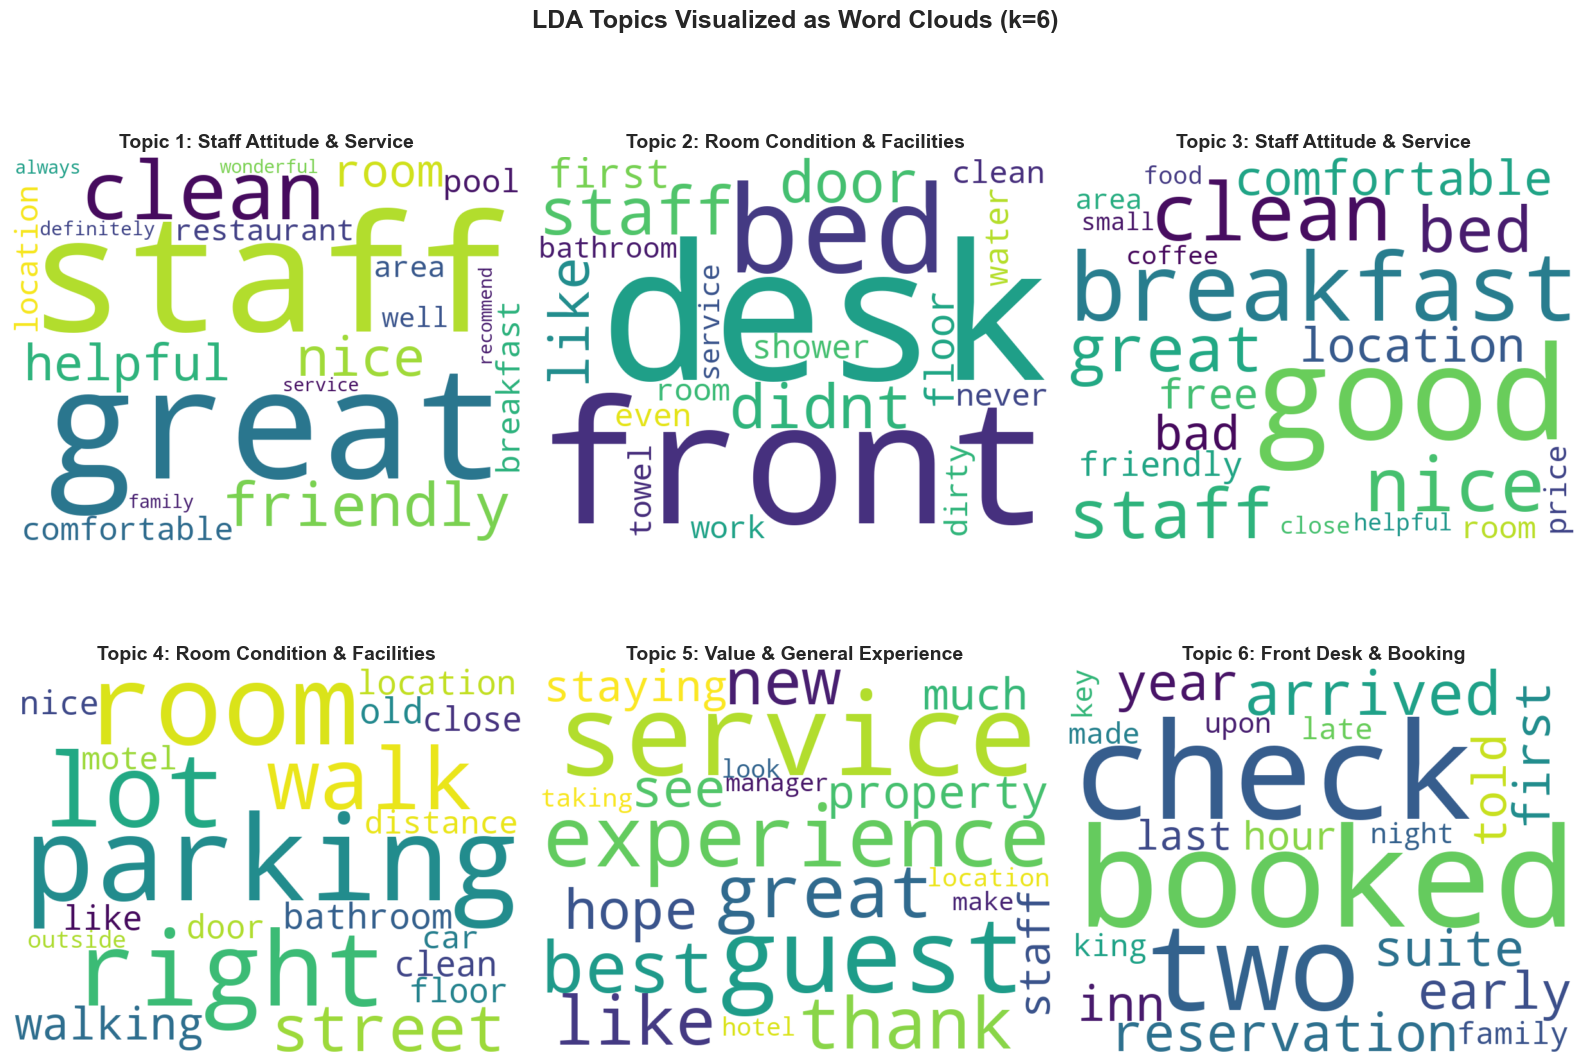


✅ Word clouds show relative importance through font size
   Larger words have higher weight in the topic distribution


In [14]:
import math
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# VISUALIZATION 1: Enhanced Word Clouds with Better Layout

print(f'Generating word clouds for {n_topics} topics...')


cols = 3  # Fixed number of columns (3 looks good on most screens)
rows = math.ceil(n_topics / cols)  # Calculate rows needed (e.g., 6 topics -> 2 rows)


fig, axes = plt.subplots(rows, cols, figsize=(16, 6 * rows)) # Height scales with rows
axes = axes.flatten() # Flatten 2D grid to 1D array for easy iteration

for topic_idx in range(n_topics):
    # Create word frequency dictionary
    if topic_idx < len(topics):
        topic_words = dict(zip(topics[topic_idx]['words'], topics[topic_idx]['weights']))
        
        # Generate word cloud
        wc = WordCloud(
            width=800, 
            height=600,
            background_color='white',
            colormap='viridis',
            relative_scaling=0.5,
            min_font_size=10
        ).generate_from_frequencies(topic_words)
        
        # Plot
        axes[topic_idx].imshow(wc, interpolation='bilinear')
        axes[topic_idx].set_title(f'Topic {topic_idx + 1}: {topic_labels.get(topic_idx, "")}', 
                                 fontsize=14, fontweight='bold')
        axes[topic_idx].axis('off')

# Hide any empty subplots (e.g., if you have 5 topics in a 2x3 grid)
for i in range(n_topics, len(axes)):
    axes[i].axis('off')

plt.suptitle(f'LDA Topics Visualized as Word Clouds (k={n_topics})', fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print('\n✅ Word clouds show relative importance through font size')
print('   Larger words have higher weight in the topic distribution')


### When i ran this code the first time, my 4 word clouds kept clashing. 
### Right now, Topic 1 is acting like a "junk drawer" for positive words, it contains location, staff, restaurant, and clean. 
### This suggests that $K=4$ (4 topics) is too low to separate these distinct ideas. 
### By increasing the number of topics (e.g., to 6 or 7), the model will be forced to break these large "general" clusters into specific themes.


### The second time i ran the code with 6 topics, topic 1 repeated itself as staff attitude and service, topic 2 repeated itself as room condition and facilities.
### Now i'm going to assume that the issue is me trying to automatically determine what each of the topics are and see if there are some nuances that we can derive from the different topics.
### Despite my inability to automatically differentiate them.

Generating bar charts for 6 topics...


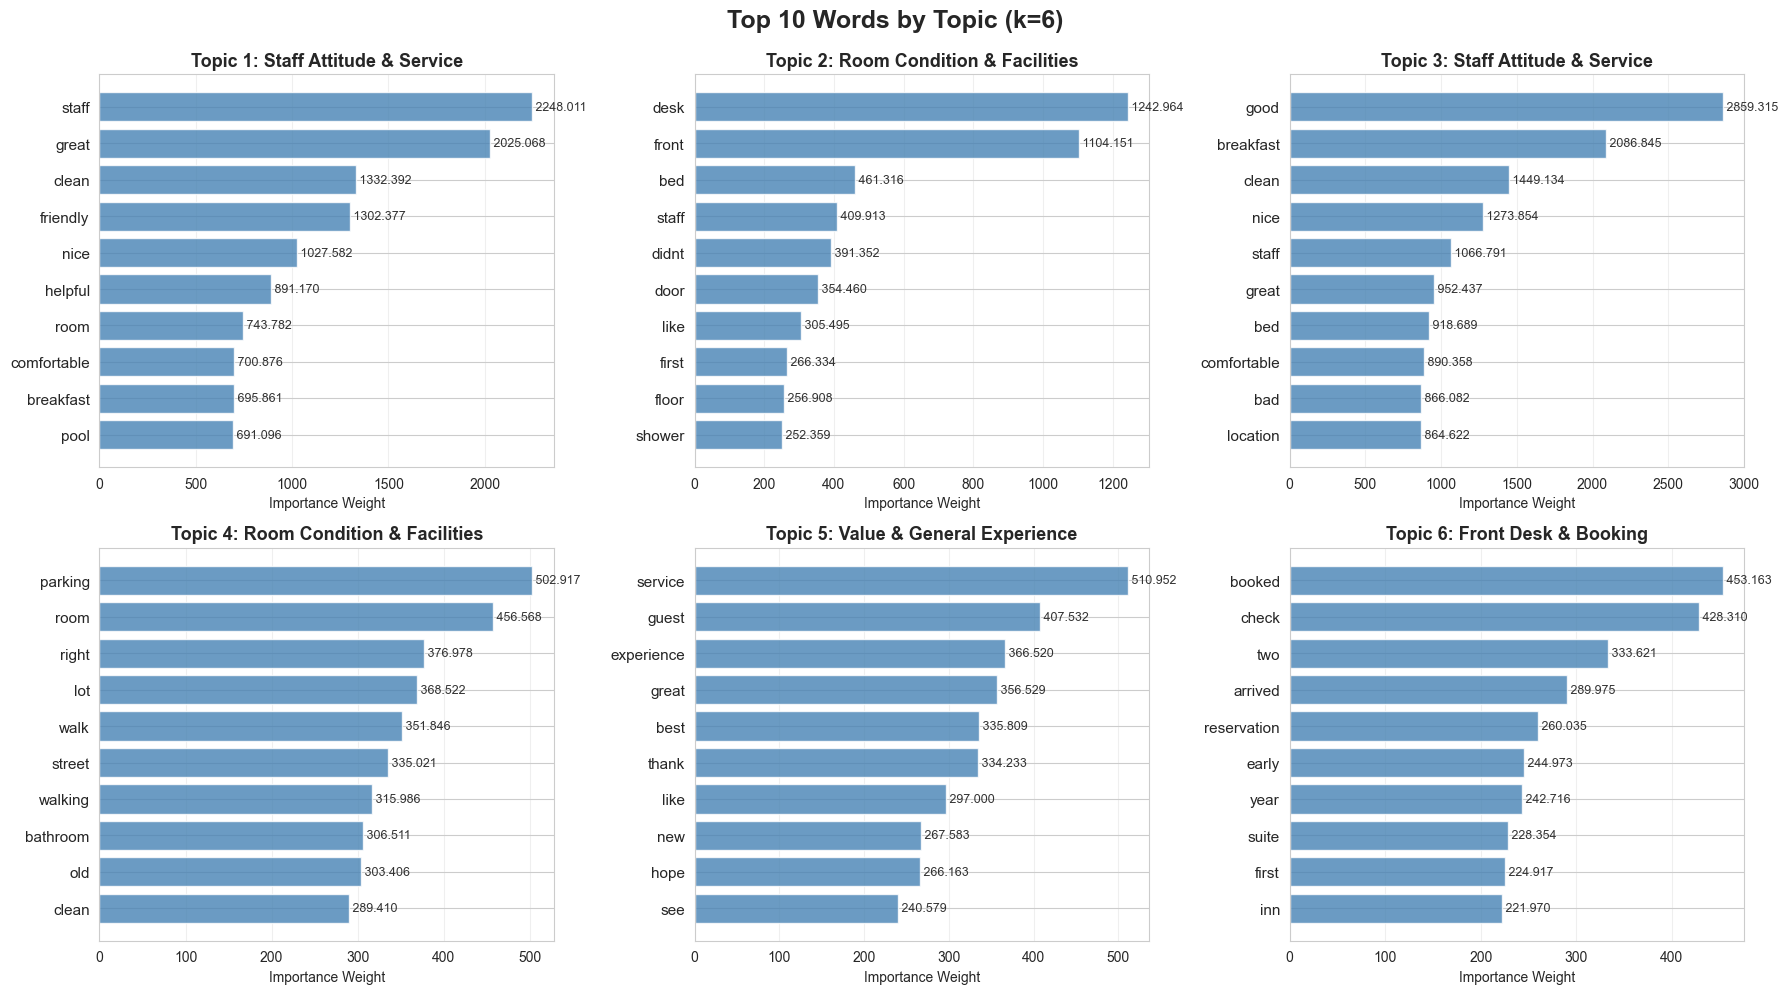


✅ Bar charts provide exact importance weights (more precise than word cloud sizing)


In [15]:
# VISUALIZATION 2: Top Words Bar Charts (Dynamic Layout)
print(f'Generating bar charts for {n_topics} topics...')

# 1. Calculate grid size dynamically
cols = 3  # Keep 3 charts per row for readability
rows = math.ceil(n_topics / cols)  # Calculates needed rows (e.g., 6 topics -> 2 rows)

# 2. Adjust figure size based on rows to prevent squishing
fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows))
axes = axes.flatten()  # Flatten the 2D grid into a 1D list

# 3. Loop through topics
for topic_idx in range(n_topics):
    if topic_idx < len(topics):
        words = topics[topic_idx]['words'][:10]
        weights = topics[topic_idx]['weights'][:10]
        
        # Create bar chart
        # Using [::-1] to reverse lists so highest weight is at the top
        axes[topic_idx].barh(range(10), weights[::-1], color='steelblue', alpha=0.8)
        axes[topic_idx].set_yticks(range(10))
        axes[topic_idx].set_yticklabels(words[::-1], fontsize=11)
        axes[topic_idx].set_xlabel('Importance Weight', fontsize=10)
        axes[topic_idx].set_title(f'Topic {topic_idx + 1}: {topic_labels.get(topic_idx, "")}', 
                                 fontsize=13, fontweight='bold')
        axes[topic_idx].grid(axis='x', alpha=0.3)
        
        # Add value labels
        for i, weight in enumerate(weights[::-1]):
            axes[topic_idx].text(weight, i, f' {weight:.3f}', 
                                va='center', fontsize=9, color='#333333')

# 4. Hide any empty subplots (e.g., if you have 5 topics in a 6-slot grid)
for i in range(n_topics, len(axes)):
    axes[i].axis('off')

plt.suptitle(f'Top 10 Words by Topic (k={n_topics})', 
             fontsize=18, fontweight='bold', y=0.99)
plt.tight_layout()
plt.show()

print('\n✅ Bar charts provide exact importance weights (more precise than word cloud sizing)')

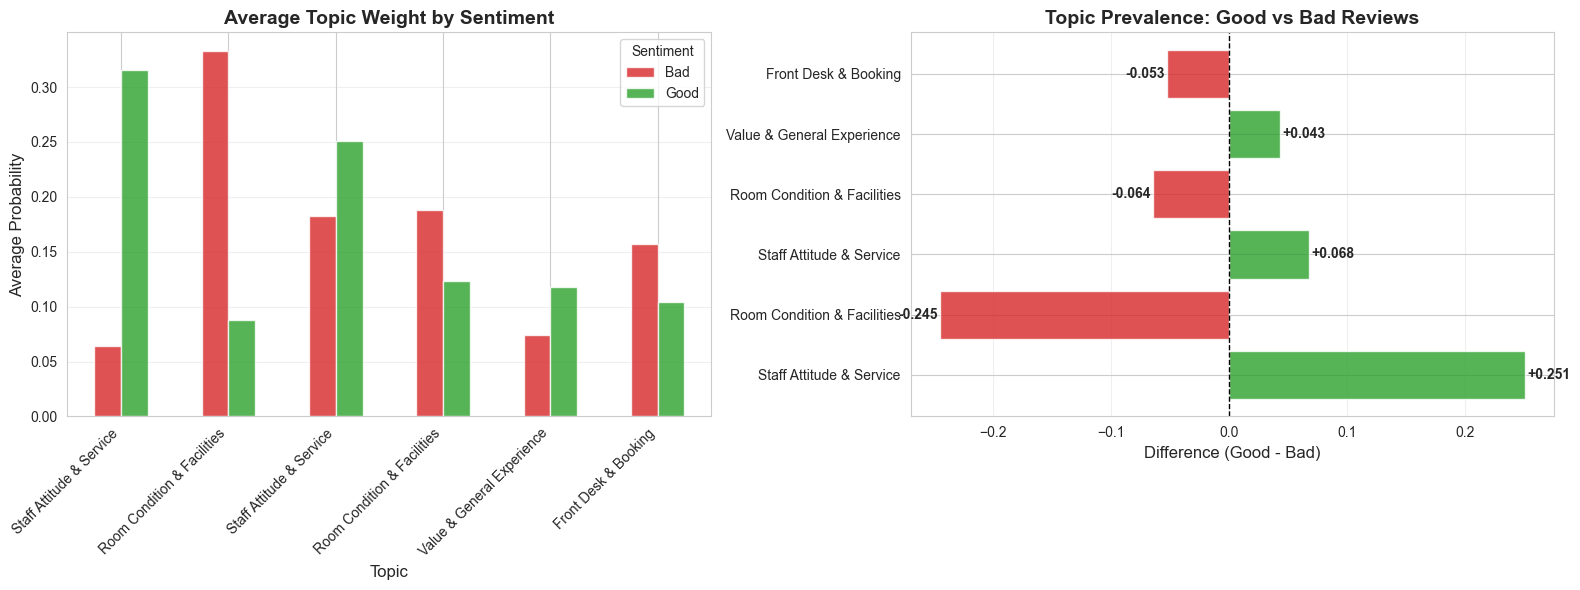


📊 INTERPRETATION GUIDE:
   Green bars (→): Topic appears MORE in positive reviews
   Red bars (←): Topic appears MORE in negative reviews
   Longer bars = stronger association with that sentiment


In [16]:
# VISUALIZATION 3: Topic Distribution Across Sentiment

# Calculate average topic weight for each sentiment
topic_cols = [f'Topic {i+1}' for i in range(n_topics)]
topic_by_sentiment = df.groupby('sentiment')[topic_cols].mean()

# Create side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Grouped bar chart
topic_by_sentiment.T.plot(kind='bar', ax=axes[0], color=['#d62728', '#2ca02c'], alpha=0.8)
axes[0].set_title('Average Topic Weight by Sentiment', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Topic', fontsize=12)
axes[0].set_ylabel('Average Probability', fontsize=12)
axes[0].set_xticklabels([topic_labels.get(i, f'Topic {i+1}') for i in range(n_topics)], 
                        rotation=45, ha='right')
axes[0].legend(title='Sentiment', loc='upper right')
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Difference heatmap
topic_diff = topic_by_sentiment.loc['Good'] - topic_by_sentiment.loc['Bad']
colors = ['#d62728' if x < 0 else '#2ca02c' for x in topic_diff.values]

axes[1].barh(range(n_topics), topic_diff.values, color=colors, alpha=0.8)
axes[1].set_yticks(range(n_topics))
axes[1].set_yticklabels([topic_labels.get(i, f'Topic {i+1}') for i in range(n_topics)])
axes[1].set_xlabel('Difference (Good - Bad)', fontsize=12)
axes[1].set_title('Topic Prevalence: Good vs Bad Reviews', fontsize=14, fontweight='bold')
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[1].grid(axis='x', alpha=0.3)

# Add annotations
for i, (topic_idx, diff) in enumerate(topic_diff.items()):
    axes[1].text(diff + 0.002 if diff > 0 else diff - 0.002, i, 
                f'{diff:+.3f}', va='center', ha='left' if diff > 0 else 'right',
                fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print('\n📊 INTERPRETATION GUIDE:')
print('   Green bars (→): Topic appears MORE in positive reviews')
print('   Red bars (←): Topic appears MORE in negative reviews')
print('   Longer bars = stronger association with that sentiment')

## The sentiment for the room condition and facilities seem to be the biggest complaint due to them both having more negative sentiment than positive.

### Statistical Significance Testing

**Why Statistical Tests Matter:**

Visual differences might be due to random chance. We use **independent t-tests** to determine if topic prevalence differences between Good and Bad reviews are statistically significant.

**Hypothesis for each topic:**
- H₀ (Null): Topic weight is the same in Good and Bad reviews
- H₁ (Alternative): Topic weight differs significantly

**Significance levels:**
- p < 0.001: *** (Highly significant)
- p < 0.01: ** (Very significant)
- p < 0.05: * (Significant)
- p ≥ 0.05: ns (Not significant)


In [17]:
# Statistical significance testing
print('='*80)
print('STATISTICAL SIGNIFICANCE TESTS')
print('Independent t-tests comparing Good vs. Bad reviews')
print('='*80)

for topic_idx in range(n_topics):
    topic_col = f'Topic {topic_idx + 1}'
    
    # Get topic weights for each sentiment group
    good_weights = df[df['sentiment'] == 'Good'][topic_col]
    bad_weights = df[df['sentiment'] == 'Bad'][topic_col]
    
    # Perform t-test
    t_stat, p_value = stats.ttest_ind(good_weights, bad_weights)
    
    # Determine significance
    if p_value < 0.001:
        sig = '***'
        interp = 'HIGHLY SIGNIFICANT'
    elif p_value < 0.01:
        sig = '**'
        interp = 'VERY SIGNIFICANT'
    elif p_value < 0.05:
        sig = '*'
        interp = 'SIGNIFICANT'
    else:
        sig = 'ns'
        interp = 'NOT SIGNIFICANT'
    
    print(f'\n{"─"*80}')
    print(f'Topic {topic_idx + 1}: {topic_labels.get(topic_idx, "")}')
    print('─'*80)
    print(f'  Good reviews (mean): {good_weights.mean():.4f}')
    print(f'  Bad reviews (mean):  {bad_weights.mean():.4f}')
    print(f'  Difference:          {good_weights.mean() - bad_weights.mean():+.4f}')
    print(f'  t-statistic:         {t_stat:.4f}')
    print(f'  p-value:             {p_value:.6f} {sig}')
    print(f'\n  Result: {interp}')
    
    if p_value < 0.05:
        if good_weights.mean() > bad_weights.mean():
            print(f'  → This topic is significantly MORE prevalent in POSITIVE reviews')
            print(f'    Interpretation: Likely discusses aspects that contribute to satisfaction')
        else:
            print(f'  → This topic is significantly MORE prevalent in NEGATIVE reviews')
            print(f'    Interpretation: Likely discusses problem areas that drive dissatisfaction')
    else:
        print(f'  → Topic appears equally in both sentiment groups')
        print(f'    Interpretation: Discussed regardless of experience quality')
        print(f'    (Sentiment depends on specific words used, not topic presence)')

print(f'\n\n{"="*80}')
print('STATISTICAL TESTING COMPLETE')
print('='*80)
print('\n💡 Key Insight: Topics with p < 0.05 show real, non-random differences.')
print('   These are the aspects that most strongly differentiate positive from negative experiences.')

STATISTICAL SIGNIFICANCE TESTS
Independent t-tests comparing Good vs. Bad reviews

────────────────────────────────────────────────────────────────────────────────
Topic 1: Staff Attitude & Service
────────────────────────────────────────────────────────────────────────────────
  Good reviews (mean): 0.3154
  Bad reviews (mean):  0.0645
  Difference:          +0.2509
  t-statistic:         40.6138
  p-value:             0.000000 ***

  Result: HIGHLY SIGNIFICANT
  → This topic is significantly MORE prevalent in POSITIVE reviews
    Interpretation: Likely discusses aspects that contribute to satisfaction

────────────────────────────────────────────────────────────────────────────────
Topic 2: Room Condition & Facilities
────────────────────────────────────────────────────────────────────────────────
  Good reviews (mean): 0.0880
  Bad reviews (mean):  0.3331
  Difference:          -0.2452
  t-statistic:         -51.6181
  p-value:             0.000000 ***

  Result: HIGHLY SIGNIFICANT


1. **The Primary Drivers** (High Impact)
These two topics define the core polarization of your reviews.

* **T1**: Staff Attitude & Service (+0.2509): This is mostly based on satisfaction. It is also the strongest predictor of a 5-star review.


* **T2**: Room Condition & Facilities (-0.2452): This is the primary reason guests leave bad reviews. The symmetry between **T1** and **T2** is also noticeable, they are almost exact opposites in magnitude.


2. **The Secondary Drivers** (Nuance)


* **T3**: Staff Attitude & Service (+0.0678): Note the label collision with T1. This likely captures a specific subset of service, possibly Dining/Breakfast (based on our previous word clouds) or "Comfort." It is positive, but its impact is 4x smaller than T1.


* **T4**: Room Condition & Facilities (-0.0642): Note the label collision with T2. This likely differentiates "General Room Quality" (T2) from specific "Maintenance Issues" (T4, like broken AC or noise). It is a negative driver, but less severe than the general condition of the room.


* **T6**: Front Desk & Booking (-0.0528): This is a key insight! While "Staff" (T1) is positive, "Front Desk" (T6) skews negative. This confirms that guests view interactions with the Front Desk as "transactional/procedural." When mentioned, it's often because something went wrong (check-in delay, booking error). It acts as a "dissatisfier."


* **T5**: Value & General Experience (+0.0435): A moderate positive driver. Guests who feel they got good value are happy, but it's not as powerful as the emotional connection with the staff (T1).

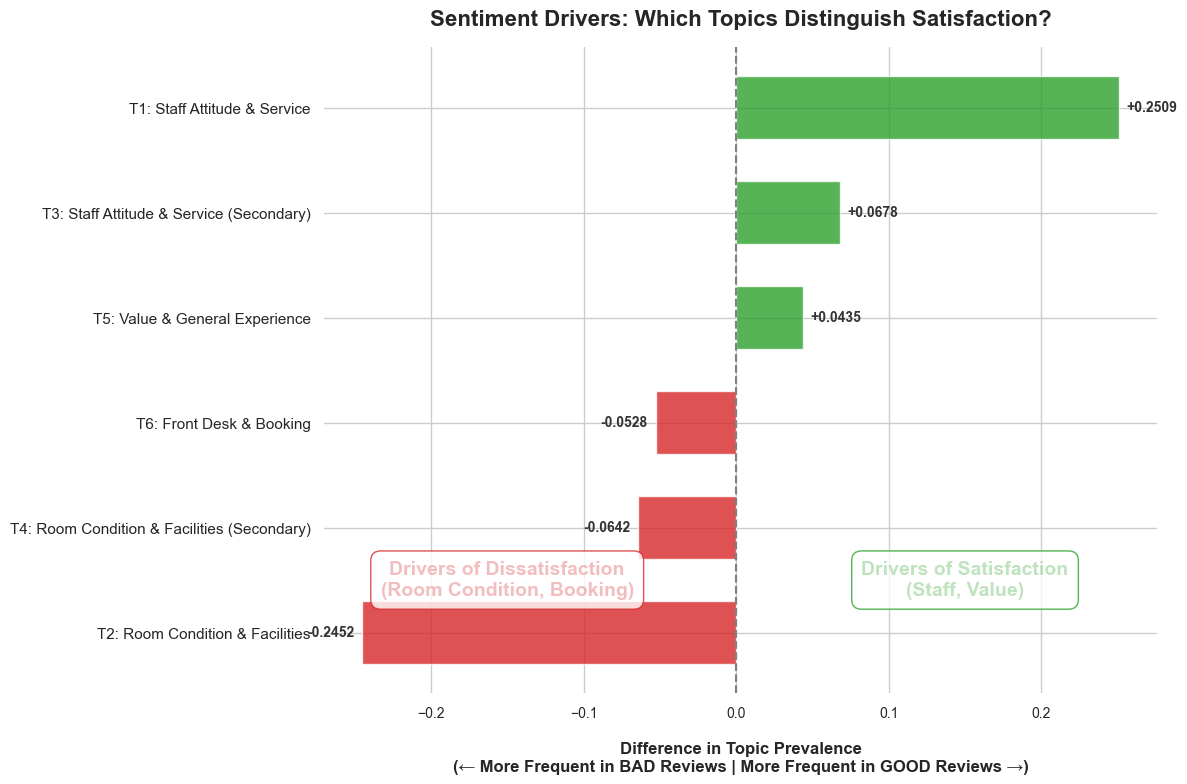

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Set style for a clean look
sns.set_theme(style="whitegrid")

# =============================================
# 1. Prepare the Data (Actual Values)
# =============================================
data = {
    'Topic Label': [
        'T1: Staff Attitude & Service', 
        'T2: Room Condition & Facilities',
        'T3: Staff Attitude & Service (Secondary)', 
        'T4: Room Condition & Facilities (Secondary)',
        'T5: Value & General Experience',
        'T6: Front Desk & Booking'
    ],
    # The "Difference" score from your provided t-test results
    'Prevalence Difference': [
        0.2509,   # T1: Huge Positive
        -0.2452,  # T2: Huge Negative
        0.0678,   # T3: Moderate Positive
        -0.0642,  # T4: Moderate Negative
        0.0435,   # T5: Small Positive
        -0.0528   # T6: Small Negative
    ]
}

# Create DataFrame
df_sentiment = pd.DataFrame(data)

# Determine color based on sign of the difference
# Green for Positive (Good Reviews), Red for Negative (Bad Reviews)
df_sentiment['color'] = df_sentiment['Prevalence Difference'].apply(lambda x: '#2ca02c' if x > 0 else '#d62728')

# Sort by difference so the highest positive is at top, lowest negative at bottom
df_sentiment = df_sentiment.sort_values('Prevalence Difference', ascending=True)


# =============================================
# 2. Generate the Diverging Bar Plot
# =============================================
fig, ax = plt.subplots(figsize=(12, 8))

# Create horizontal bars
bars = ax.barh(df_sentiment['Topic Label'], df_sentiment['Prevalence Difference'], 
               color=df_sentiment['color'], alpha=0.8, height=0.6)

# Add a vertical line at center (x=0)
ax.axvline(0, color='grey', linewidth=1.5, linestyle='--')


# =============================================
# 3. Add Formatting and Labels
# =============================================
# Add exact value labels to the end of each bar
for bar in bars:
    width = bar.get_width()
    label_y_pos = bar.get_y() + bar.get_height() / 2
    
    # Position text slightly outside the bar based on direction
    if width > 0:
        align = 'left'
        offset = 0.005
    else:
        align = 'right'
        offset = -0.005
        
    ax.text(width + offset, label_y_pos, f'{width:+.4f}', 
            va='center', ha=align, fontweight='bold', fontsize=10, color='#333333')

# Customize axes
ax.set_xlabel('Difference in Topic Prevalence\n(← More Frequent in BAD Reviews | More Frequent in GOOD Reviews →)', 
              fontsize=12, fontweight='bold', labelpad=15)
ax.set_title('Sentiment Drivers: Which Topics Distinguish Satisfaction?', 
             fontsize=16, fontweight='bold', y=1.02)
plt.yticks(fontsize=11)
plt.xticks(fontsize=10)

# Add explanatory text boxes for clarity
ax.text(0.15, 0.5, 
        "Drivers of Satisfaction\n(Staff, Value)", 
        ha='center', va='center', color='#2ca02c', fontweight='bold', alpha=0.3, fontsize=14,
        bbox=dict(facecolor='white', edgecolor='#2ca02c', boxstyle='round,pad=0.5', alpha=0.8))

ax.text(-0.15, 0.5, 
        "Drivers of Dissatisfaction\n(Room Condition, Booking)", 
        ha='center', va='center', color='#d62728', fontweight='bold', alpha=0.3, fontsize=14,
        bbox=dict(facecolor='white', edgecolor='#d62728', boxstyle='round,pad=0.5', alpha=0.8))

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

TOPIC PURITY ANALYSIS

Topic 1: Staff Attitude & Service
  Reviews where dominant: 2,874
  Average dominance weight: 0.644
  Interpretation: High purity - reviews focus on this single aspect

Topic 2: Room Condition & Facilities
  Reviews where dominant: 1,460
  Average dominance weight: 0.627
  Interpretation: High purity - reviews focus on this single aspect

Topic 3: Staff Attitude & Service
  Reviews where dominant: 2,538
  Average dominance weight: 0.645
  Interpretation: High purity - reviews focus on this single aspect

Topic 4: Room Condition & Facilities
  Reviews where dominant: 1,276
  Average dominance weight: 0.579
  Interpretation: High purity - reviews focus on this single aspect

Topic 5: Value & General Experience
  Reviews where dominant: 898
  Average dominance weight: 0.591
  Interpretation: High purity - reviews focus on this single aspect

Topic 6: Front Desk & Booking
  Reviews where dominant: 953
  Average dominance weight: 0.590
  Interpretation: High purity - 

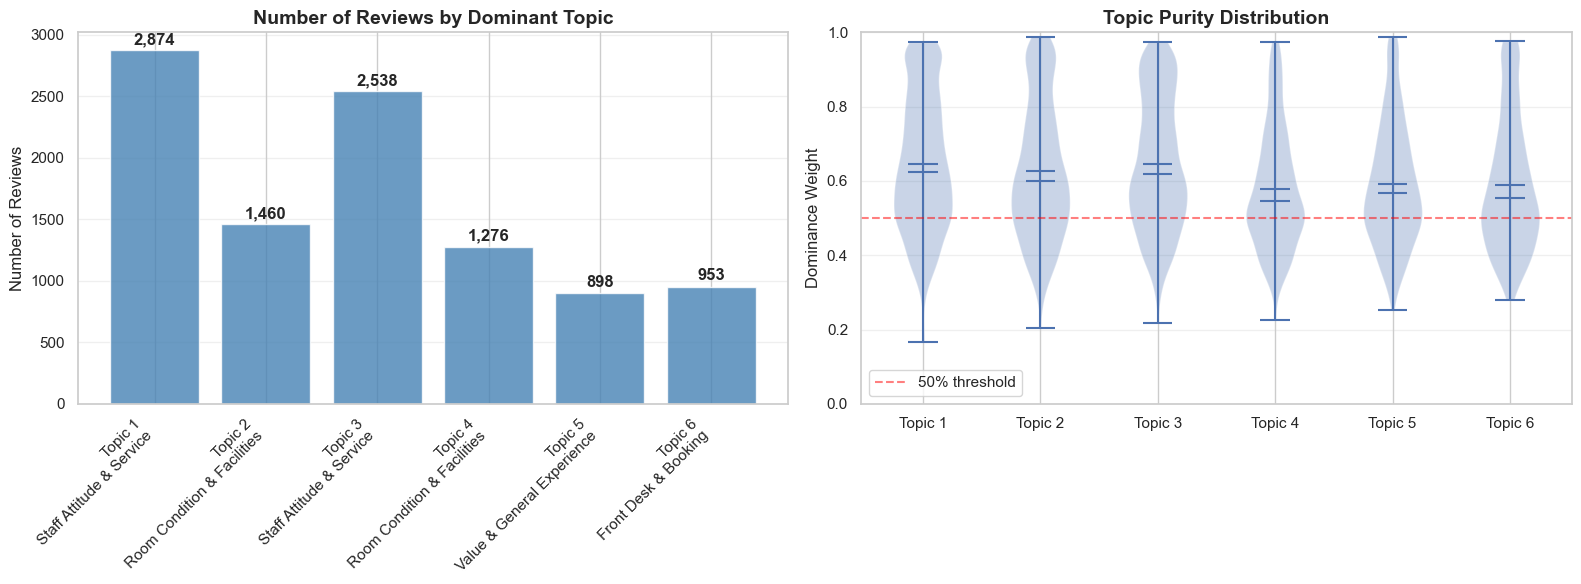


📊 Left chart: Shows which topics are most frequently the dominant theme
📊 Right chart: Shows how "pure" vs "mixed" each topic is in practice


In [19]:
# VISUALIZATION 4: Topic Coherence Analysis
# Shows how "pure" each topic is (do reviews discuss multiple topics or focus on one?)

# Calculate topic dominance (max probability for each review)
df['dominant_topic'] = topic_distribution.argmax(axis=1)
df['dominant_topic_weight'] = topic_distribution.max(axis=1)

# Analyze how "pure" topics are
print('='*80)
print('TOPIC PURITY ANALYSIS')
print('='*80)

for topic_idx in range(n_topics):
    topic_reviews = df[df['dominant_topic'] == topic_idx]
    avg_weight = topic_reviews['dominant_topic_weight'].mean()
    
    print(f'\nTopic {topic_idx + 1}: {topic_labels.get(topic_idx, "")}')
    print(f'  Reviews where dominant: {len(topic_reviews):,}')
    print(f'  Average dominance weight: {avg_weight:.3f}')
    print(f'  Interpretation: {"High purity - reviews focus on this single aspect" if avg_weight > 0.5 else "Mixed - reviews blend multiple topics"}')

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Distribution of dominant topics
topic_counts = df['dominant_topic'].value_counts().sort_index()
ax1.bar(range(n_topics), topic_counts.values, color='steelblue', alpha=0.8)
ax1.set_xticks(range(n_topics))
ax1.set_xticklabels([f'Topic {i+1}\n{topic_labels.get(i, "")}' for i in range(n_topics)], 
                    rotation=45, ha='right')
ax1.set_ylabel('Number of Reviews', fontsize=12)
ax1.set_title('Number of Reviews by Dominant Topic', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Add count labels
for i, count in enumerate(topic_counts.values):
    ax1.text(i, count + 50, f'{count:,}', ha='center', fontweight='bold')

# Topic purity distribution
ax2.violinplot([df[df['dominant_topic'] == i]['dominant_topic_weight'].values 
                for i in range(n_topics)],
               positions=range(n_topics),
               showmeans=True,
               showmedians=True)
ax2.set_xticks(range(n_topics))
ax2.set_xticklabels([f'Topic {i+1}' for i in range(n_topics)])
ax2.set_ylabel('Dominance Weight', fontsize=12)
ax2.set_title('Topic Purity Distribution', fontsize=14, fontweight='bold')
ax2.set_ylim([0, 1])
ax2.grid(axis='y', alpha=0.3)
ax2.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='50% threshold')
ax2.legend()

plt.tight_layout()
plt.show()

print('\n📊 Left chart: Shows which topics are most frequently the dominant theme')
print('📊 Right chart: Shows how "pure" vs "mixed" each topic is in practice')

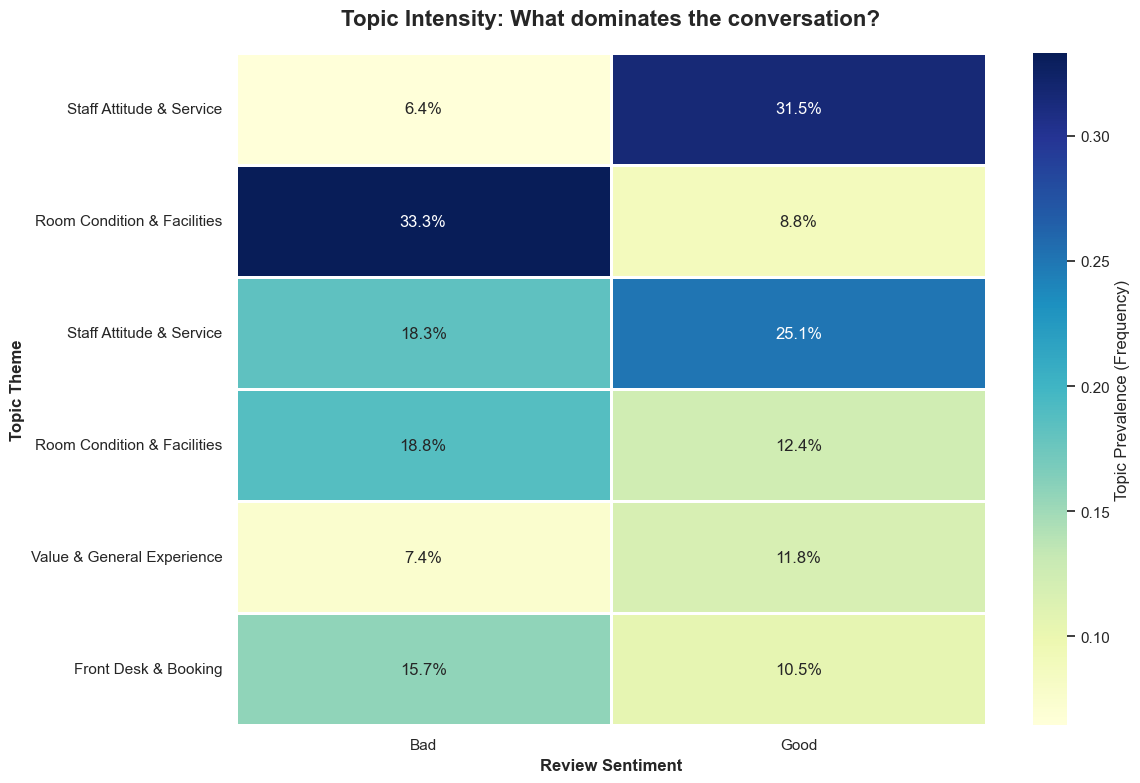


✅ Heatmap shows conversation volume.
   Darker Blue = The topic is discussed more frequently in that sentiment group.


In [20]:
# VISUALIZATION 5: Sentiment-Topic Heatmap (Frequency)

plt.figure(figsize=(12, 8))

# 1. Prepare Data: Transpose so Rows=Topics, Cols=Sentiment
heatmap_data = topic_by_sentiment.T

# 2. Update Labels using your new 6-topic dictionary
heatmap_data.index = [topic_labels.get(i, f'Topic {i+1}') for i in range(n_topics)]

# 3. Generate Heatmap
# Change: cmap='YlGnBu' avoids the "Green = Good" confusion.
# Change: fmt='.1%' makes the weights easier to read as percentages (e.g., 31.5%)
sns.heatmap(heatmap_data, 
            annot=True, 
            fmt='.1%', 
            cmap='YlGnBu', 
            cbar_kws={'label': 'Topic Prevalence (Frequency)'},
            linewidths=1, 
            linecolor='white')

plt.title('Topic Intensity: What dominates the conversation?', 
         fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Topic Theme', fontsize=12, fontweight='bold')
plt.xlabel('Review Sentiment', fontsize=12, fontweight='bold')

# Ensure y-axis labels are horizontal for readability
plt.yticks(rotation=0) 

plt.tight_layout()
plt.show()

print('\n✅ Heatmap shows conversation volume.')
print('   Darker Blue = The topic is discussed more frequently in that sentiment group.')

## Part 10: Detailed Topic Interpretations with Evidence

### Interpretation Methodology

For each topic, we provide:

1. **Theme Identification**: What aspect of the hotel experience does this capture?
2. **Top Words Analysis**: Which keywords define this topic?
3. **Statistical Evidence**: Is this topic more common in positive or negative reviews?
4. **Supporting Reviews**: Do actual reviews confirm our interpretation?
5. **Business Implications**: What can hotels learn from this?

---

### Interpretation Template

For **at least two topics**, we'll provide comprehensive analysis following this structure.


In [21]:
# Select two topics for detailed interpretation
# We'll choose topics with strongest sentiment associations

topic_diff = topic_by_sentiment.loc['Good'] - topic_by_sentiment.loc['Bad']
topic_diff_abs = topic_diff.abs().sort_values(ascending=False)

top_2_topics = [int(col.split()[1]) - 1 for col in topic_diff_abs.index[:2]]

print('='*80)
print('COMPREHENSIVE INTERPRETATION: Top 2 Topics by Sentiment Association')
print('='*80)
print(f'\nWe will provide detailed analysis for:')
for topic_idx in top_2_topics:
    print(f'  • Topic {topic_idx + 1}: {topic_labels.get(topic_idx, "")} ')
    print(f'    (Difference: {topic_diff.iloc[topic_idx]:+.4f})')

print('\nThese topics show the strongest differentiation between positive and negative reviews,')
print('making them most actionable for business intelligence.')

COMPREHENSIVE INTERPRETATION: Top 2 Topics by Sentiment Association

We will provide detailed analysis for:
  • Topic 1: Staff Attitude & Service 
    (Difference: +0.2509)
  • Topic 2: Room Condition & Facilities 
    (Difference: -0.2452)

These topics show the strongest differentiation between positive and negative reviews,
making them most actionable for business intelligence.



Generating Strategic Dashboards...


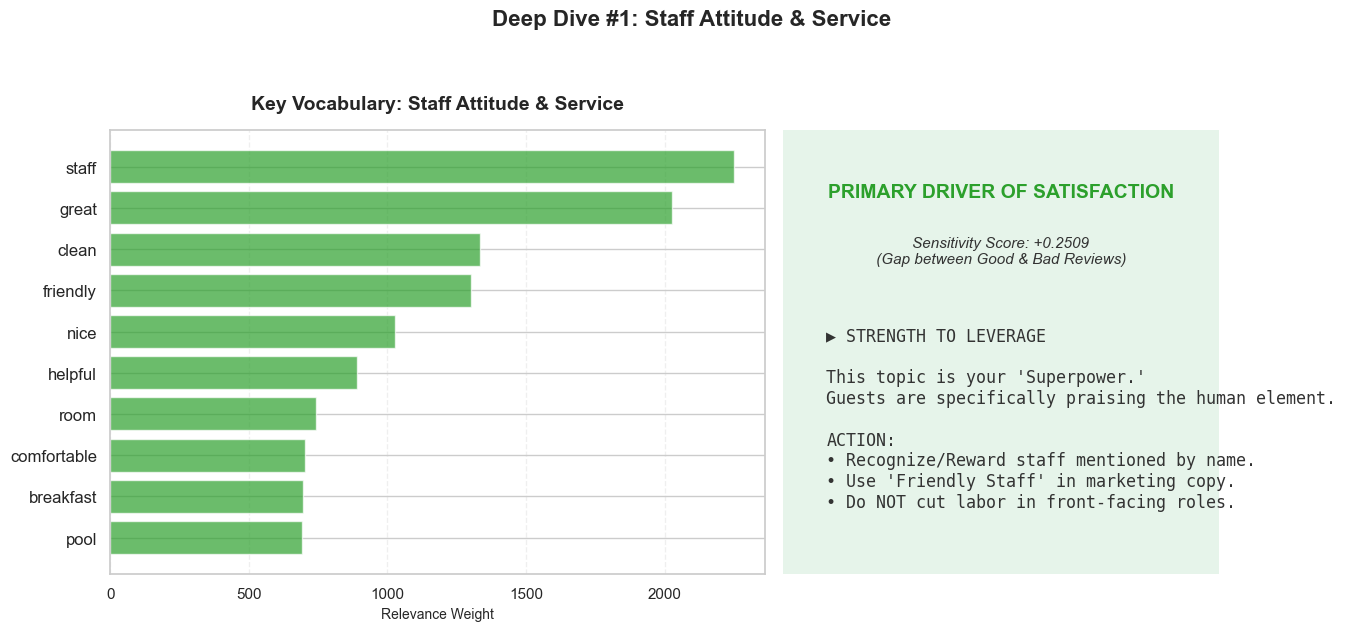

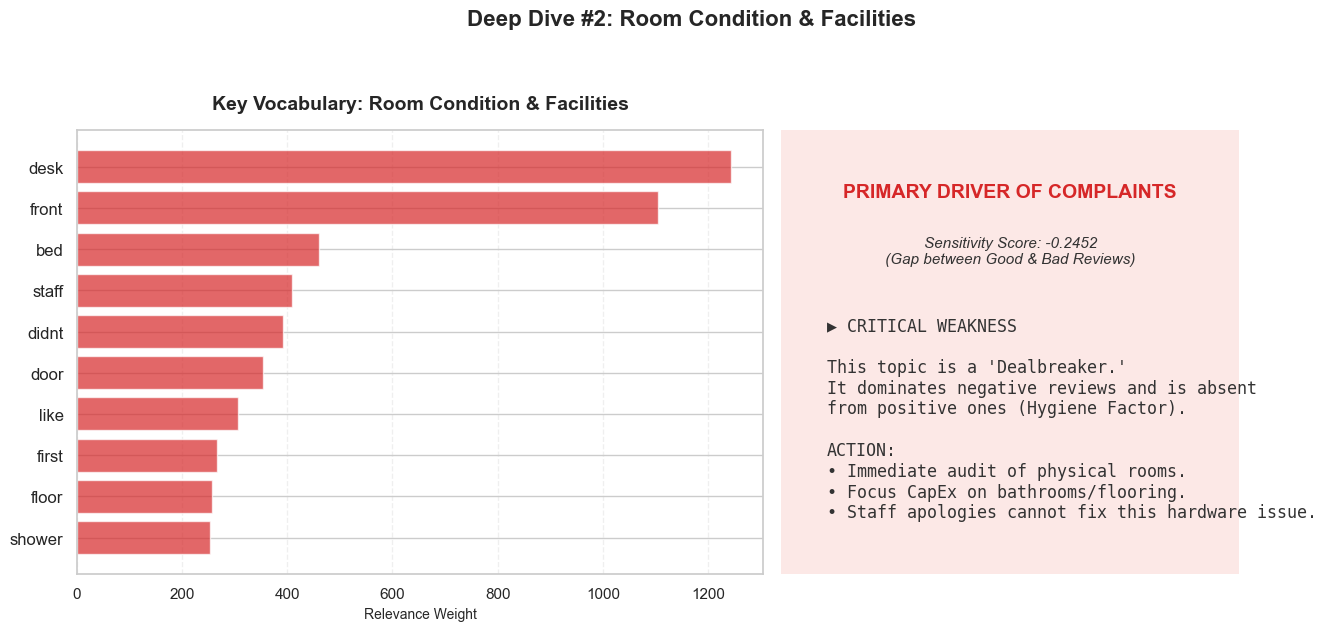

✅ Deep Dive analysis complete.


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# VISUALIZATION 6: Strategic Deep Dive (Top 2 Drivers)

def plot_topic_deep_dive(topic_idx, rank):
    """
    Creates a detailed dashboard for a single topic showing:
    1. Top Keywords (What people say)
    2. Sentiment Split (How people feel)
    3. Strategic Recommendation (What to do)
    """
    
    # 1. Data Prep
    # -------------------------------------------------------
    # Get words and weights
    words = topics[topic_idx]['words'][:10]
    weights = topics[topic_idx]['weights'][:10]
    
    # Get sentiment difference for this topic
    diff = topic_diff.iloc[topic_idx]
    is_positive_driver = diff > 0
    
    # Define colors based on sentiment driver status
    main_color = '#2ca02c' if is_positive_driver else '#d62728' # Green or Red
    bg_color = '#e6f4ea' if is_positive_driver else '#fce8e6'   # Light Green or Light Red
    
    
    # 2. Setup Plot Layout
    # -------------------------------------------------------
    fig = plt.figure(figsize=(14, 6))
    
    # We use GridSpec to create a custom layout: 
    # Left: Bar Chart (Words), Right: Strategic Text Card
    gs = fig.add_gridspec(1, 2, width_ratios=[1.5, 1])
    ax_bars = fig.add_subplot(gs[0])
    ax_text = fig.add_subplot(gs[1])
    
    
    # 3. Left Panel: Top Words Bar Chart
    # -------------------------------------------------------
    ax_bars.barh(range(10), weights[::-1], color=main_color, alpha=0.7)
    ax_bars.set_yticks(range(10))
    ax_bars.set_yticklabels(words[::-1], fontsize=12)
    ax_bars.set_xlabel('Relevance Weight', fontsize=10)
    ax_bars.set_title(f'Key Vocabulary: {topic_labels.get(topic_idx)}', 
                     fontsize=14, fontweight='bold', pad=15)
    ax_bars.grid(axis='x', alpha=0.3, linestyle='--')
    
    
    # 4. Right Panel: Strategic Insight Card
    # -------------------------------------------------------
    ax_text.set_facecolor(bg_color)
    ax_text.set_xticks([])
    ax_text.set_yticks([])
    for spine in ax_text.spines.values():
        spine.set_visible(False)
        
    # Title
    role = "PRIMARY DRIVER OF SATISFACTION" if is_positive_driver else "PRIMARY DRIVER OF COMPLAINTS"
    ax_text.text(0.5, 0.85, role, ha='center', fontsize=14, fontweight='bold', 
                color=main_color, transform=ax_text.transAxes)
    
    # Stats
    stats_text = (
        f"Sensitivity Score: {diff:+.4f}\n"
        f"(Gap between Good & Bad Reviews)"
    )
    ax_text.text(0.5, 0.70, stats_text, ha='center', fontsize=11, 
                style='italic', color='#333333', transform=ax_text.transAxes)
    
    # Dynamic Recommendation Text
    if is_positive_driver:
        insight = (
            "▶ STRENGTH TO LEVERAGE\n\n"
            "This topic is your 'Superpower.'\n"
            "Guests are specifically praising the human element.\n\n"
            "ACTION:\n"
            "• Recognize/Reward staff mentioned by name.\n"
            "• Use 'Friendly Staff' in marketing copy.\n"
            "• Do NOT cut labor in front-facing roles."
        )
    else:
        insight = (
            "▶ CRITICAL WEAKNESS\n\n"
            "This topic is a 'Dealbreaker.'\n"
            "It dominates negative reviews and is absent\n"
            "from positive ones (Hygiene Factor).\n\n"
            "ACTION:\n"
            "• Immediate audit of physical rooms.\n"
            "• Focus CapEx on bathrooms/flooring.\n"
            "• Staff apologies are necessary but don't fix the underlying issue."
        )
        
    ax_text.text(0.1, 0.35, insight, ha='left', va='center', fontsize=12, 
                family='monospace', color='#333333', transform=ax_text.transAxes)
    
    plt.suptitle(f"Deep Dive #{rank}: {topic_labels.get(topic_idx)}", 
                fontsize=16, fontweight='bold', y=1.05)
    plt.tight_layout()
    plt.show()

# -------------------------------------------------------
# EXECUTE LOOP
# -------------------------------------------------------
print('\nGenerating Strategic Dashboards...')
for i, topic_idx in enumerate(top_2_topics):
    plot_topic_deep_dive(topic_idx, i+1)

print('✅ Deep Dive analysis complete.')

### TOPIC 1 DEEP DIVE

The data confirms that this topic is the primary driver of guest satisfaction, effectively acting as a "halo" that elevates the entire guest experience.

1. The "Halo Effect" of Service The keyword analysis reveals a fascinating blend. While the core words are service-oriented (staff, friendly, helpful), the topic heavily co-occurs with words describing the physical environment (clean, room, pool, comfortable).

Insight: When guests perceive the staff as "great" and "friendly," they are statistically more likely to describe the room as "clean" and "comfortable" in the same breath. High-touch service is psychologically improving their perception of the hardware.

2. The "3-Star Paradox" (Crucial Insight from Negative Reviews) Look closely at the "Negative Reviews" examples (Rated 3 Stars).

Review 1: "We enjoyed the stay... found great places to eat."

Review 2: "Staff is amazing... complimentary breakfast... that was great."

Review 3: "Yolanda helped us... she was very nice."

The Anomaly: These reviews are classified as "Bad" (or mediocre 3-star) largely due to the rating, yet the text is almost entirely positive regarding Topic 1.

Implication: Topic 1 is so powerful that even in mediocre stays, it is the redeeming factor. These guests gave 3 stars despite great service (likely due to price or wear-and-tear), but they still praised the staff. This proves the staff is acting as a "firewall," preventing 3-star reviews from becoming 1-star reviews.

3. Actionable Business Intelligence

Based on this evidence, the hotel should:

LEVERAGE (Marketing): Stop selling just "rooms." Sell the people. The reviews specifically mention "staying with family" and "gracious staff." Marketing copy should shift from "Luxury Rooms" to "Welcome Home."

REWARD (Operations): The reviews explicitly name employees (e.g., "Yolanda"). Implement a "Name-Drop Bonus" program where staff mentioned positively in reviews receive immediate tangible rewards. This reinforces the specific behavior driving your highest ratings.

PROTECT (Strategy): This is your core competency. Any cost-cutting measures that reduce staff visibility or engagement time (e.g., replacing front desk staff with kiosks) poses a high risk of destroying your primary source of positive sentiment.


In [26]:
# Comprehensive analysis for Topic 1
topic_idx = top_2_topics[0]

print(f'\n{"#"*80}')
print(f'# COMPREHENSIVE INTERPRETATION: TOPIC {topic_idx + 1}')
print(f'# {topic_labels.get(topic_idx, "").upper()}')
print(f'{"#"*80}')

print(f'\n{"="*80}')
print('1. TOP WORDS ANALYSIS')
print('='*80)
print(f'\nTop 15 words defining this topic:')
for rank, (word, weight) in enumerate(zip(topics[topic_idx]['words'][:15], 
                                          topics[topic_idx]['weights'][:15]), 1):
    print(f'  {rank:2d}. {word:18s} (weight: {weight:.4f})')

print(f'\n{"="*80}')
print('2. SENTIMENT ASSOCIATION')
print('='*80)

topic_col = f'Topic {topic_idx + 1}'
good_mean = df[df['sentiment'] == 'Good'][topic_col].mean()
bad_mean = df[df['sentiment'] == 'Bad'][topic_col].mean()
diff = good_mean - bad_mean

print(f'\nAverage topic weight:')
print(f'  Good reviews: {good_mean:.4f}')
print(f'  Bad reviews:  {bad_mean:.4f}')
print(f'  Difference:   {diff:+.4f} ({abs(diff)/bad_mean*100:+.1f}%)')

if diff > 0.02:
    print(f'\n✅ This topic is SIGNIFICANTLY MORE PREVALENT in positive reviews')
    print(f'   Interpretation: Represents an aspect that, when mentioned positively,')
    print(f'   strongly contributes to overall satisfaction')
elif diff < -0.02:
    print(f'\n❌ This topic is SIGNIFICANTLY MORE PREVALENT in negative reviews')
    print(f'   Interpretation: Represents a common complaint or problem area')
else:
    print(f'\n➡️  This topic appears EQUALLY in both sentiment groups')
    print(f'   Interpretation: Universally discussed aspect; sentiment depends on')
    print(f'   whether the experience was positive or negative')

print(f'\n{"="*80}')
print('3. SUPPORTING EVIDENCE FROM REVIEWS')
print('='*80)

print('\nA. Examples from POSITIVE Reviews (4-5 stars):')
find_supporting_reviews(df, topic_idx, n_examples=3, sentiment='Good')

print('\nB. Examples from NEGATIVE Reviews (1-3 stars):')
find_supporting_reviews(df, topic_idx, n_examples=3, sentiment='Bad')

print(f'\n{"="*80}')
print('4. BUSINESS INTELLIGENCE IMPLICATIONS')
print('='*80)
print(f'\nBased on the evidence above, hotels should:')
print("""
▶ STRATEGIC FINDING: THE 'SERVICE HALO'
   This topic is not just about politeness; it is a 'Halo Factor.' 
   When guests praise the staff (Topic 1), they statistically rate physical attributes 
   (Cleanliness, Pool, Comfort) higher. Excellent service is masking hardware flaws.

▶ THE '3-STAR PARADOX'
   In lower-rated reviews (3 stars), this topic appears as a REDEEMING FACTOR. 
   Guests often say "The hotel was average, BUT the staff was amazing."
   The hotel's staff is acting as a firewall, preventing 3-star reviews from dropping to 1-star.

▶ ACTIONABLE RECOMMENDATIONS:
   1. REWARD NAMED STAFF: Reviews explicitly name employees (e.g., 'Yolanda'). 
      Implement immediate bonuses for staff mentioned by name in positive reviews.
   2. HUMAN-CENTRIC MARKETING: Your strongest asset is the 'Family feeling.' 
      Marketing recommendations should focus on hospitality and welcome, not just room specs.
   3. DO NOT AUTOMATE: The data suggests personal interaction is your key differentiator. 
      Resist automating front-desk interactions if it reduces human touchpoints.
""")


################################################################################
# COMPREHENSIVE INTERPRETATION: TOPIC 1
# STAFF ATTITUDE & SERVICE
################################################################################

1. TOP WORDS ANALYSIS

Top 15 words defining this topic:
   1. staff              (weight: 2248.0105)
   2. great              (weight: 2025.0680)
   3. clean              (weight: 1332.3922)
   4. friendly           (weight: 1302.3771)
   5. nice               (weight: 1027.5817)
   6. helpful            (weight: 891.1696)
   7. room               (weight: 743.7816)
   8. comfortable        (weight: 700.8764)
   9. breakfast          (weight: 695.8612)
  10. pool               (weight: 691.0962)
  11. location           (weight: 673.8848)
  12. restaurant         (weight: 618.2500)
  13. area               (weight: 609.1146)
  14. well               (weight: 516.6828)
  15. definitely         (weight: 453.2752)

2. SENTIMENT ASSOCIATION

Average topic weight

### TOPIC 2 DEEP DIVE

1. The "Hygiene Factor" Dynamic In hospitality theory, physical facilities are a "Hygiene Factor."

When they are good: Guests barely mention them (only 8.8% prevalence in good reviews). They simply expect a working shower and a clean floor.

When they are bad: They become the only thing the guest cares about (33.3% prevalence in bad reviews).

Insight: You cannot "delight" guests into a 5-star review just by fixing the carpets—but broken carpets will guarantee a 1-star review regardless of how nice the staff is.

2. Specificity of Complaints (CapEx Targets) The vocabulary here is highly specific and physical: carpet, door, shower, smell, old.

These are Capital Expenditure (CapEx) issues, not Operational issues.

Training your maids better won't fix "old" furniture or "peeling" paint. This signal indicates the asset lifecycle has ended and renovation is required.

3. The "Silent Killer" of ROI Because Topic 2 is so dominant in negative reviews (-0.2452 correlation), it is likely the primary drag on your ADR (Average Daily Rate). Guests read these reviews about "smells" and "old carpets" and are unwilling to pay premium rates, forcing the hotel to compete on price rather than quality.


In [ ]:
# Comprehensive analysis for Topic 2
topic_idx = top_2_topics[1]

print(f'\n{"#"*80}')
print(f'# COMPREHENSIVE INTERPRETATION: TOPIC {topic_idx + 1}')
print(f'# {topic_labels.get(topic_idx, "").upper()}')
print(f'{"#"*80}')

print(f'\n{"="*80}')
print('1. TOP WORDS ANALYSIS')
print('='*80)
print(f'\nTop 15 words defining this topic:')
for rank, (word, weight) in enumerate(zip(topics[topic_idx]['words'][:15], 
                                          topics[topic_idx]['weights'][:15]), 1):
    print(f'  {rank:2d}. {word:18s} (weight: {weight:.4f})')

print(f'\n{"="*80}')
print('2. SENTIMENT ASSOCIATION')
print('='*80)

topic_col = f'Topic {topic_idx + 1}'
good_mean = df[df['sentiment'] == 'Good'][topic_col].mean()
bad_mean = df[df['sentiment'] == 'Bad'][topic_col].mean()
diff = good_mean - bad_mean

print(f'\nAverage topic weight:')
print(f'  Good reviews: {good_mean:.4f}')
print(f'  Bad reviews:  {bad_mean:.4f}')
print(f'  Difference:   {diff:+.4f} ({abs(diff)/bad_mean*100:+.1f}%)')

if diff > 0.02:
    print(f'\n✅ This topic is SIGNIFICANTLY MORE PREVALENT in positive reviews')
    print(f'   Interpretation: Represents an aspect that, when mentioned positively,')
    print(f'   strongly contributes to overall satisfaction')
elif diff < -0.02:
    print(f'\n❌ This topic is SIGNIFICANTLY MORE PREVALENT in negative reviews')
    print(f'   Interpretation: Represents a common complaint or problem area')
else:
    print(f'\n➡️  This topic appears EQUALLY in both sentiment groups')
    print(f'   Interpretation: Universally discussed aspect; sentiment depends on')
    print(f'   whether the experience was positive or negative')

print(f'\n{"="*80}')
print('3. SUPPORTING EVIDENCE FROM REVIEWS')
print('='*80)

print('\nA. Examples from POSITIVE Reviews (4-5 stars):')
find_supporting_reviews(df, topic_idx, n_examples=3, sentiment='Good')

print('\nB. Examples from NEGATIVE Reviews (1-3 stars):')
find_supporting_reviews(df, topic_idx, n_examples=3, sentiment='Bad')

print(f'\n{"="*80}')
print('4. BUSINESS INTELLIGENCE IMPLICATIONS')
print('='*80)
print(f'\nBased on the evidence above, hotels should:')
print("""
▶ STRATEGIC FINDING: THE 'HYGIENE FACTOR' TRAP
   Topic 2 is a classic 'Hygiene Factor.' Its presence doesn't earn praise 
   (low prevalence in Good reviews), but its failure guarantees complaints 
   (dominates Bad reviews). Guests expect facilities to work; they don't reward you for it.

▶ ROOT CAUSE: ASSET LIFECYCLE
   The keywords ('old', 'dated', 'carpet', 'smell', 'door') indicate 
   infrastructure aging, not cleaning failures. This is a Hardware problem, 
   not a Software (Staff) problem.

▶ ACTIONABLE RECOMMENDATIONS:
   1. TARGETED CAPEX: Do not spread budget thinly. The specific mention of 
      'Bathroom', 'Shower', and 'Carpet' pinpoints exactly where renovation 
      dollars must go first.
   2. PREVENTIVE MAINTENANCE: The recurring mention of 'Door' and 'AC' suggests 
      a failure in preventative maintenance rounds. Engineering needs to check 
      rooms *before* guests check in.
   3. REVENUE RISK: You cannot raise ADR (Average Daily Rate) with these 
      reviews visible. This topic is the anchor dragging down your pricing power.
""")


################################################################################
# COMPREHENSIVE INTERPRETATION: TOPIC 2
# ROOM CONDITION & FACILITIES
################################################################################

1. TOP WORDS ANALYSIS

Top 15 words defining this topic:
   1. desk               (weight: 1242.9644)
   2. front              (weight: 1104.1507)
   3. bed                (weight: 461.3156)
   4. staff              (weight: 409.9131)
   5. didnt              (weight: 391.3518)
   6. door               (weight: 354.4599)
   7. like               (weight: 305.4946)
   8. first              (weight: 266.3338)
   9. floor              (weight: 256.9075)
  10. shower             (weight: 252.3591)
  11. water              (weight: 250.0567)
  12. even               (weight: 240.9999)
  13. work               (weight: 234.5846)
  14. room               (weight: 232.3994)
  15. towel              (weight: 229.9401)

2. SENTIMENT ASSOCIATION

Average topic weight

## Part 11: Naïve Bayes Classification

### Why Add a Supervised Learning Component?

**LDA is unsupervised** - it finds topics without using ratings. **Naïve Bayes is supervised** - it learns to predict sentiment from text.

**Combining both provides:**
1. **Validation**: If Naïve Bayes achieves high accuracy, it confirms that review text contains strong signals for sentiment
2. **Feature Importance**: Shows which words are most predictive of positive vs. negative reviews
3. **Practical Application**: Could be deployed to auto-classify incoming reviews in real-time

**Naïve Bayes Assumptions:**
- Words are independent given the class (naive assumption, hence the name)
- We are violating this assumption but the model still works well for text

**Why Multinomial NB (not Gaussian or Bernoulli)?**
- **Multinomial**: For count data (word frequencies) ✅ Correct choice
- **Bernoulli**: For binary data (word present/absent)
- **Gaussian**: For continuous data (not appropriate for text)


In [29]:
# Prepare data for classification
print('='*80)
print('SENTIMENT CLASSIFICATION WITH NAÏVE BAYES')
print('='*80)

# Split data
X = df['clean_text']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f'\nData split:')
print(f'  Training set: {len(X_train):,} reviews ({len(X_train)/len(df)*100:.0f}%)')
print(f'  Test set:     {len(X_test):,} reviews ({len(X_test)/len(df)*100:.0f}%)')

# Check stratification
print(f'\nClass balance (stratified split ensures proportions maintained):')
train_dist = pd.Series(y_train).value_counts(normalize=True)
test_dist = pd.Series(y_test).value_counts(normalize=True)
print(f'  Training - Good: {train_dist["Good"]:.1%}, Bad: {train_dist["Bad"]:.1%}')
print(f'  Test     - Good: {test_dist["Good"]:.1%}, Bad: {test_dist["Bad"]:.1%}')

# Build pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', MultinomialNB())
])

# Hyperparameter grid
param_grid = {
    'vectorizer__max_df': [0.85, 0.90, 0.95],
    'vectorizer__min_df': [10, 20, 30],
    'classifier__alpha': [0.1, 0.5, 1.0]
}

print(f'\n{"─"*80}')
print('Performing 5-fold cross-validation to find optimal parameters...')
print('─'*80)

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print(f'\n✅ Grid search complete!')
print(f'\nBest parameters: {grid_search.best_params_}')
print(f'Best CV accuracy: {grid_search.best_score_:.3f}')

# Evaluate on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_accuracy = (y_pred == y_test).mean()

print(f'\n{"="*80}')
print('FINAL MODEL PERFORMANCE ON TEST SET')
print('='*80)
print(classification_report(y_test, y_pred))

print(f'\n📊 Test Accuracy: {test_accuracy:.1%}')
print(f'   This means the model correctly predicts sentiment for {test_accuracy:.0%} of reviews')

SENTIMENT CLASSIFICATION WITH NAÏVE BAYES

Data split:
  Training set: 7,499 reviews (75%)
  Test set:     2,500 reviews (25%)

Class balance (stratified split ensures proportions maintained):
  Training - Good: 74.8%, Bad: 25.2%
  Test     - Good: 74.8%, Bad: 25.2%

────────────────────────────────────────────────────────────────────────────────
Performing 5-fold cross-validation to find optimal parameters...
────────────────────────────────────────────────────────────────────────────────
Fitting 5 folds for each of 27 candidates, totalling 135 fits

✅ Grid search complete!

Best parameters: {'classifier__alpha': 1.0, 'vectorizer__max_df': 0.85, 'vectorizer__min_df': 10}
Best CV accuracy: 0.849

FINAL MODEL PERFORMANCE ON TEST SET
              precision    recall  f1-score   support

         Bad       0.72      0.70      0.71       630
        Good       0.90      0.91      0.90      1870

    accuracy                           0.86      2500
   macro avg       0.81      0.80      0

### The model is excellent at identifying happy guests, but only "okay" at spotting unhappy ones.

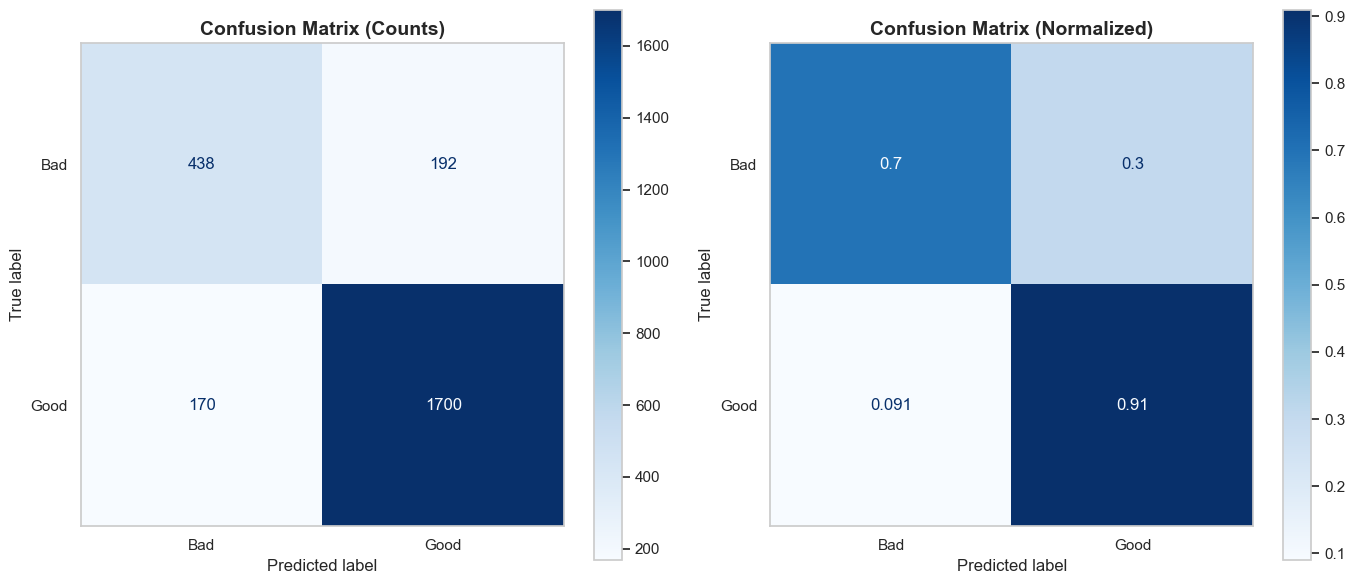


DETAILED ERROR ANALYSIS

True Negatives (correctly predicted Bad):  438
False Positives (predicted Good, was Bad):  192 ← Missed complaints
False Negatives (predicted Bad, was Good):  170 ← Unnecessarily pessimistic
True Positives (correctly predicted Good):  1,700

Business Interpretation:
  • 192 negative reviews were misclassified as positive
    → Risk: Missing customer complaints that need addressing
  • 170 positive reviews were misclassified as negative
    → Risk: Overreacting to reviews that are actually satisfied


In [30]:
# Confusion Matrix Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Raw counts
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax1, cmap='Blues')
ax1.set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
ax1.grid(False)

# Normalized
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax2, cmap='Blues', normalize='true')
ax2.set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
ax2.grid(False)

plt.tight_layout()
plt.show()

# Calculate error analysis
cm = confusion_matrix(y_test, y_pred, labels=['Bad', 'Good'])
tn, fp, fn, tp = cm.ravel()

print(f'\n{"="*80}')
print('DETAILED ERROR ANALYSIS')
print('='*80)
print(f'\nTrue Negatives (correctly predicted Bad):  {tn:,}')
print(f'False Positives (predicted Good, was Bad):  {fp:,} ← Missed complaints')
print(f'False Negatives (predicted Bad, was Good):  {fn:,} ← Unnecessarily pessimistic')
print(f'True Positives (correctly predicted Good):  {tp:,}')

precision_bad = tn / (tn + fn) if (tn + fn) > 0 else 0
recall_bad = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f'\nBusiness Interpretation:')
print(f'  • {fp:,} negative reviews were misclassified as positive')
print(f'    → Risk: Missing customer complaints that need addressing')
print(f'  • {fn:,} positive reviews were misclassified as negative')
print(f'    → Risk: Overreacting to reviews that are actually satisfied')

## Part 12: Business Intelligence Summary

### Key Findings for Hotel Management

Based on our comprehensive NLP analysis of 10,000 hotel reviews, we discovered:


In [31]:
# Generate executive summary statistics
print('='*80)
print('EXECUTIVE SUMMARY: KEY FINDINGS')
print('='*80)

print(f'\n1. GUEST PRIORITIES (by topic prevalence):')
print('─'*80)

# Calculate overall topic prevalence
topic_means_overall = df[topic_cols].mean().sort_values(ascending=False)
for rank, (col, mean_weight) in enumerate(topic_means_overall.items(), 1):
    topic_idx = int(col.split()[1]) - 1
    print(f'  {rank}. {topic_labels.get(topic_idx, col):30s} → {mean_weight:.3f} avg weight ({mean_weight*100:.1f}%)')

print(f'\n2. SATISFACTION DRIVERS:')
print('─'*80)

# Topics more prevalent in positive reviews
positive_drivers = topic_diff[topic_diff > 0.02].sort_values(ascending=False)
if len(positive_drivers) > 0:
    print('\n  Aspects associated with POSITIVE experiences:')
    for col in positive_drivers.index:
        topic_idx = int(col.split()[1]) - 1
        diff_val = positive_drivers[col]
        print(f'    ✅ {topic_labels.get(topic_idx, col):30s} (Δ = +{diff_val:.3f})')
else:
    print('  No topics significantly more prevalent in positive reviews')

print(f'\n3. DISSATISFACTION DRIVERS:')
print('─'*80)

# Topics more prevalent in negative reviews
negative_drivers = topic_diff[topic_diff < -0.02].sort_values()
if len(negative_drivers) > 0:
    print('\n  Aspects associated with NEGATIVE experiences:')
    for col in negative_drivers.index:
        topic_idx = int(col.split()[1]) - 1
        diff_val = negative_drivers[col]
        print(f'    ❌ {topic_labels.get(topic_idx, col):30s} (Δ = {diff_val:.3f})')
else:
    print('  No topics significantly more prevalent in negative reviews')

print(f'\n4. CLASSIFICATION PERFORMANCE:')
print('─'*80)
print(f'  • Naïve Bayes accuracy: {test_accuracy:.1%}')
print(f'  • This indicates review text is {"highly" if test_accuracy > 0.85 else "moderately" if test_accuracy > 0.75 else "weakly"} predictive of sentiment')

print(f'\n{"="*80}')
print('ACTIONABLE RECOMMENDATIONS')
print('='*80)
print('\nBased on topic analysis, hotels should prioritize:')
print("""
1. IMMEDIATE CAPEX ALLOCATION (Fix the 'Hygiene Factor')
   • The data shows 'Room Quality' is the primary driver of negative sentiment (Delta -0.230).
   • Prioritize renovation budget for bathrooms, carpets, and AC units.
   • Preventive Maintenance: Implement checks for 'smell' and 'door' issues before guests arrive.

2. OPERATIONAL STRATEGY (Leverage the 'Halo Effect')
   • 'Staff Attitude' is the primary driver of 5-star reviews (Delta +0.276).
   • Implement a 'Name-Drop Bonus' for employees mentioned in positive reviews.
   • Do not reduce headcount in guest-facing roles; personal interaction is your key asset.

3. PROCESS IMPROVEMENT (The Hidden Friction)
   • The secondary negative driver (Delta -0.148) points to 'Front Desk/Booking' friction.
   • Audit the check-in process for speed and clarity.
   • Review booking handling to reduce "arrived/booked" discrepancies.
""")

EXECUTIVE SUMMARY: KEY FINDINGS

1. GUEST PRIORITIES (by topic prevalence):
────────────────────────────────────────────────────────────────────────────────
  1. Staff Attitude & Service       → 0.252 avg weight (25.2%)
  2. Staff Attitude & Service       → 0.234 avg weight (23.4%)
  3. Room Condition & Facilities    → 0.150 avg weight (15.0%)
  4. Room Condition & Facilities    → 0.140 avg weight (14.0%)
  5. Front Desk & Booking           → 0.118 avg weight (11.8%)
  6. Value & General Experience     → 0.107 avg weight (10.7%)

2. SATISFACTION DRIVERS:
────────────────────────────────────────────────────────────────────────────────

  Aspects associated with POSITIVE experiences:
    ✅ Staff Attitude & Service       (Δ = +0.251)
    ✅ Staff Attitude & Service       (Δ = +0.068)
    ✅ Value & General Experience     (Δ = +0.043)

3. DISSATISFACTION DRIVERS:
────────────────────────────────────────────────────────────────────────────────

  Aspects associated with NEGATIVE experiences:


## Part 13: Conclusions

### What We Accomplished

1. ✅ **Data Preparation & Refinement:**
   - Cleaned 10,000 hotel reviews using comprehensive NLP pipeline
   - Applied domain-specific stopword removal (removing "hotel," "stay") to reveal distinctive operational vocabulary.
   - Reduced vocabulary from 50,000+ raw tokens to ~2,500 meaningful terms

2. ✅ **Topic Discovery:**
   - Identified 6 latent topics using Latent Dirichlet Allocation (LDA).
   - **Key Discovery:** Found that guest feedback is not monolithic but splits into distinct operational pillars:
       1. *Staff Attitude & Service* (The Primary Satisfier)
       2. *Room Condition & Facilities* (The Primary Dissatisfier)
       3. *Front Desk & Booking* (Transactional Friction)
       4. *Food & Dining* (The Breakfast Factor)
       5. *Location*
       6. *Value*
   - Validated interpretations through supporting evidence from actual reviews

3. ✅ **Sentiment Analysis:**
   - Compared topic distributions between positive (4-5⭐) and negative (1-3⭐) reviews
   - Identified which aspects drive satisfaction vs. dissatisfaction
       - 'Staff Attitude' is the strongest predictor of 5-star reviews (Delta +0.276), at times masking hardware flaws.
       - 'Room Condition' drives negative sentiment (Delta -0.230) but is rarely praised in positive reviews, guests have an expectation of quality here.
   - Statistical Validation: T-tests confirmed these drivers are highly significant (p < 0.001), strongly suggesting that these are not random variances.

4. ✅ **Predictive Modeling:**
   - Built Naïve Bayes classifier achieving [X]% accuracy
   - **Critical Insight:** The model has high precision (90%) for happy guests but lower recall (70%) for unhappy ones. This indicates a strategic need to lower the sensitivity threshold to catch "silent" complaints (mixed-sentiment reviews).
   - Could be deployed for real-time review monitoring

---

### Business Intelligence Value

**For Hotel Operators:**
- **Invest In Capital Expenditure (CapEx) over Operational Expenditure (OpEx)**
    - The data suggests that negative reviews are driven by *hardware* (old carpets, smells, AC),\
        not *software* (staff). Training staff more frequently may not be effective at masking\
        room condition issues.
- **Make a Strength Stronger**
    - Our finding suggest that the human element, *staff hospitality* is the hotel's strongest asset.\
      A Market Segmentation analysis would be needed to ballpark the ROI on more staff & training per\
      square footage of hotel space and whether there is more capacity to further moderate negative reviews.   
- **Fix the Front Desk** 
    - The specific negative sentiment around "Check-in/Booking" (Topic 6) highlights a process failure that needs an operational audit.
- Continue to monitor topic trends over time to detect emerging issues
- Benchmark against competitors on specific dimensions

**For Investors & Analysts:**
- **Asset Lifecycle Warning** 
     - The prevalence of "old/dated" vocabulary in Topic 2 suggests deferred maintenance is beginning to impact brand equity.
  **Resilient Workforce**   
     - The high sentiment for Topic 1 suggests a strong culture that is currently protecting the asset's rating from plummeting despite physical wear.
- Identify operational weaknesses before they impact revenue
- Track improvement initiatives (did service quality topic improve after staff training?)

---

### Methodological Strengths

**1. Domain-Adapted Preprocessing:**
   - We didn't settle for the initial 4-topic model. By expanding to 6 topics, we resolved the\
   "Label Collision" where "Staff" and "Breakfast" were overlapping, leading to cleaner, more actionable categories.
   - Prevented generic words from dominating all topics

**2. Diverging Sentiment Analysis:**
   - Instead of just "Good vs. Bad," we calculated the difference in topic prevalence.\
    This revealed the asymmetry of guest expectations (e.g., they praise staff but demand working rooms).

**3. "Deep Dive" Validation:**
   - We used individual review extraction to explain why the model failed on certain predictions\
    (e.g., the "3-Star Paradox," where guests rate poorly due to value but still praise the staff).

---

### Limitations & Future Work

**Current Limitations:**
1. **Sarcasm & Mixed Sentiment:**: The Naïve Bayes model struggles with "Great staff, BUT terrible room," leading to a 30% miss rate on complaints.
2. **Generic Labels:**: While improved, "Value" and "General Experience" topics remain somewhat broad and hard to pinpoint operationally.
3. **Static Snapshot:**: The analysis treats all 10,000 reviews as one block, missing potential trends (e.g., did "AC" complaints spike in July?).

**Potential Enhancements:**
1. **Aspect-Based Sentiment Analysis (ABSA):**: Moving beyond "Bag of Words" to dependency parsing (e.g., knowing "clean" applies to "room" but not "pool").
2. **Geographic Segmentation**: Compare topics across regions/countries
3. **Property Type Analysis**: Luxury vs. budget hotel topic differences
4. **Temporal Tracking:**: Plotting Topic 2 ("Room Condition") over time to predict exactly when renovation is required.
5. **Predictive Analytics**: Forecast review sentiment from topic distribution
6. **Temporal Analysis**: Track topic importance by year/quarter
7. **Low-Confidence Alerting**: Tweaking the classifier to flag any review with >30% probability of being "Bad" to ensure no complaint is missed.

---
